# ANALYZE tld_reseller model performance comparison - with reseller_geo

In [1]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [2]:
# install.packages("pkgcond")

In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_05_metalearning"

In [52]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')


source('../phaseII_03_forest/load_prep_data_expiry.R')

# expiry_train_prepped_2_1 (list, less df's w/ 0 obs)
# expiry_test_prepped_2_1  (list, less df's w/ 0 obs)
# expiry_train_df_1 (above, rbound)
# expiry_test_df_1 (above, rbound)
# expiry_train_df_sub (subset vars)                                        
# expiry_test_df_sub (subset vars)

### add geo

In [60]:
# expiry_train_prepped_geo <- lapply(expiry_train_prepped_2_1, function(x){
#  x <- merge(x,geoLookupDF,on=c('reseller','reseller_country'), how='left')
#  return(x)
# })
expiry_train_df_geo <- rbindlist(expiry_train_prepped_geo, use.names=TRUE)

In [62]:
length(expiry_train_prepped_2_1)
length(expiry_train_prepped_geo)

[1] 1723

[1] 1723

In [61]:
dim(expiry_train_df_1)
dim(expiry_train_df_geo)
head(expiry_train_df_geo)


[1] 1188250      39

[1] 1183436      40

reseller,reseller_country,renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,reseller_geo
<chr>,<chr>,<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<chr>
1&1 internet,Germany,FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1,EU


In [ ]:
tld_reseller_names = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
   pull(tld_registrar_index)

tld_reseller_names_2 = expiry_train_df_2 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
   pull(tld_registrar_index)

length(tld_reseller_names)
length(tld_reseller_names_2)

## List tld_reseller labels

In [5]:
tld_reseller_lookup_df = expiry_train_df_1 %>% group_by(tld_registrar_index, reseller) %>% tally() %>% arrange(desc(n))
tld_reseller_lookup_df %>% head()

tld_registrar_index,reseller,n
<chr>,<chr>,<int>
sitegmo,gmo,106569
funalibaba,alibaba,72690
sitenamecheap,namecheap,53536
pwnamecheap,namecheap,50470
onlinego daddy,go daddy,42162
sitegandi sas,gandi sas,35309


## Load PREPed tld_reseller compare

In [6]:
predictions_df <- read.csv("../../data/tld_reseller_compare_predictions.csv")
metrics_df <- read.csv("../../data/tld_reseller_compare_metrics.csv")

dim(predictions_df)
head(predictions_df)
dim(metrics_df)
head(metrics_df)

[1] 297100     12

,actual,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,tld_registrar_index,reseller,n,domain_id,domain
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,Not Renewd,0.6470992,0.558,0.419,0.4765771,0.4545657,0.5386137,sitegmo,gmo,106569,44295183,kagen.site
2,Renewed,0.6762222,0.567,0.397,0.5410605,0.5769973,0.6091513,sitegmo,gmo,106569,44573611,designlab.site
3,Renewed,0.9098495,0.835,0.410,0.7018108,0.6343404,0.6886680,sitegmo,gmo,106569,45304858,hokatu-blog.site
4,Renewed,0.6029350,0.515,0.402,0.2414726,0.3999603,0.3464197,sitegmo,gmo,106569,46235129,suzuya.site
5,Not Renewd,0.9311321,0.863,0.417,0.7749462,0.7039504,0.6711740,sitegmo,gmo,106569,46276970,wins-company.site
6,Renewed,0.9347869,0.861,0.391,0.6376848,0.6566740,0.6717237,sitegmo,gmo,106569,47809960,yamatoku-company.site


[1] 1723   15

,tld_registrar_index,reseller,n,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,sitegmo,gmo,106569,8.204334,8.126935,6.408669,8.777090,8.761610,8.591331,0.8958204,0.8825077,0.8729102,0.9345201,0.9348297,0.9329721
2,funalibaba,alibaba,72690,4.883721,5.255814,5.023256,5.813953,6.000000,6.186047,0.8262791,0.8430233,0.8518605,0.8769767,0.8779070,0.8793023
3,sitenamecheap,namecheap,53536,2.298025,1.921005,1.885099,2.280072,2.028725,2.046679,0.6862657,0.6196589,0.6338420,0.6654399,0.6792639,0.6893178
4,pwnamecheap,namecheap,50470,3.478261,3.675889,3.675889,3.438735,4.071146,4.308300,0.7274704,0.6551383,0.6361660,0.7167984,0.7405138,0.7507905
5,onlinego daddy,go daddy,42162,2.850995,2.883271,2.474449,2.598171,2.727273,2.646584,0.6506455,0.6493007,0.6381119,0.6095481,0.6266541,0.6249328
6,sitegandi sas,gandi sas,35309,8.243243,8.445946,7.094595,4.932432,8.445946,8.581081,0.9202703,0.9195946,0.9189189,0.7162162,0.9344595,0.9358108


## Add reseller_geo to train_df before feature eng

In [10]:
head(expiry_train_df_1)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1
FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1
FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1
FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1
FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1
FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1


In [9]:
system("gsutil cp gs://data_input/PredictiveModelAnalysis_AnomalyRegistrars.csv /home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_AnomalyRegistrars.csv")
anomalyDF <- read.csv("/home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_AnomalyRegistrars.csv")
anomalyDF <- apply(anomalyDF, 2, function(x) trimws(x,which = c("both")) )
geoLookupDF <- unique(anomalyDF[,c('reseller','reseller_country','reseller_geo')])

In [56]:
dim(expiry_train_df_1)
expiry_train_df_2 <- merge(expiry_train_df_1,geoLookupDF,on=c('reseller','reseller_country'), how='left')
dim(expiry_train_df_2)
head(expiry_train_df_2)


[1] 1188250      39

[1] 1183436      40

reseller,reseller_country,renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,reseller_geo
<chr>,<chr>,<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<chr>
1&1 internet,Germany,FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1,EU


In [55]:
tld_reseller_names = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
   pull(tld_registrar_index)

tld_reseller_names_2 = expiry_train_df_2 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
   pull(tld_registrar_index)

length(tld_reseller_names)
length(tld_reseller_names_2)

[1] 1723

[1] 1680

In [15]:
# number of unique reseller_country and reseller_geo for eachtld_registrar_index
expiry_train_df_1 %>%
  group_by(tld_registrar_index) %>%
  summarise(u_cntry = n_distinct(reseller_country),
         u_geo = n_distinct(reseller_geo))  %>%
  filter(u_cntry>1)

`summarise()` ungrouping output (override with `.groups` argument)



tld_registrar_index,u_cntry,u_geo
<chr>,<int>,<int>
onlineuk2,2,2
siteuk2,2,2
spacealpnames,2,1
spaceuk2,2,2
storeuk2,2,2
websiteuk2,2,2


## Feature Engineering for tld-reseller level 

In [32]:
# new geo level feature eng
geo_maj = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_geo) %>%
  group_by(tld_registrar_index) %>%
  mutate(geo_maj = reseller_geo[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,geo_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(geo_maj)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [33]:
# new geo level feature eng
geo_cnt = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_geo) %>%
  group_by(tld_registrar_index) %>%
  summarise(geo_cnt = n_distinct(reseller_geo)) %>%
  pull(geo_cnt)  

`summarise()` ungrouping output (override with `.groups` argument)



In [34]:
count_pct <- function(df) {
  return(
    df %>%
      tally %>% 
      mutate(n_prp = n/sum(n))
  )
}

In [50]:
tld_reseller_names = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
   pull(tld_registrar_index)

In [36]:
count_obs = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
    pull(n)

In [37]:
ren_prp = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), ren_prp = sum(renewal_status=='Renewed')/sum(n))  %>% 
    arrange(desc(n)) %>% 
    pull(ren_prp)

`summarise()` ungrouping output (override with `.groups` argument)



In [38]:
# not informative -- tld_cnt always = 1 so tld_rat is ismply mult.inverse of count_obs
tld_rat = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), tld_cnt = n_distinct(tld), tld_rat = tld_cnt/n) %>% 
    arrange(desc(n)) %>%
    pull(tld_rat)

`summarise()` ungrouping output (override with `.groups` argument)



In [39]:
country_maj = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  mutate(reseller_country_maj = reseller_country[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,reseller_country_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(reseller_country_maj)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [40]:
country_cnt = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_country_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_country_cnt)  

`summarise()` ungrouping output (override with `.groups` argument)



In [41]:
region_maj = expiry_train_df_1 %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  mutate(region_maj = region[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,region_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(region_maj)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [42]:
region_cnt = expiry_train_df_1 %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_region_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_region_cnt)  

`summarise()` ungrouping output (override with `.groups` argument)



In [43]:
daydom_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              daydom_min = min(day_domains), 
              daydom_max = max(day_domains), 
              daydom_mean = mean(day_domains, na.rm = TRUE), 
              daydom_rng = daydom_max - daydom_min, 
              daydom_std = sd(day_domains, na.rm = TRUE), 
              daydom_skew = skewness(day_domains, na.rm = TRUE), 
              daydom_kurt = kurtosis(day_domains, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

daydom_min <- daydom_stats %>% pull(daydom_min)
daydom_max <- daydom_stats %>% pull(daydom_max)
daydom_mean <- daydom_stats %>% pull(daydom_mean)
daydom_rng <- daydom_stats %>% pull(daydom_rng)
daydom_std <- daydom_stats %>% pull(daydom_std)
daydom_skew <- daydom_stats %>% pull(daydom_skew)
daydom_kurt <- daydom_stats %>% pull(daydom_kurt)



`summarise()` ungrouping output (override with `.groups` argument)



In [44]:
sldlen_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(sld_length), 
              max = max(sld_length), 
              mean = mean(sld_length, na.rm = TRUE), 
              rng = max - min, 
              std = sd(sld_length, na.rm = TRUE), 
              skew = skewness(sld_length, na.rm = TRUE), 
              kurt = kurtosis(sld_length, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

sldlen_min <- sldlen_stats %>% pull(min)
sldlen_max <- sldlen_stats %>% pull(max)
sldlen_mean <- sldlen_stats %>% pull(mean)
sldlen_rng <- sldlen_stats %>% pull(rng)
sldlen_std <- sldlen_stats %>% pull(std)
sldlen_skew <- sldlen_stats %>% pull(skew)
sldlen_kurt <- sldlen_stats %>% pull(kurt)



`summarise()` ungrouping output (override with `.groups` argument)



In [45]:
gibbs_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(gibb_score), 
              max = max(gibb_score), 
              mean = mean(gibb_score, na.rm = TRUE), 
              rng = max - min, 
              std = sd(gibb_score, na.rm = TRUE), 
              skew = skewness(gibb_score, na.rm = TRUE), 
              kurt = kurtosis(gibb_score, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

gibbs_min <- gibbs_stats %>% pull(min)
gibbs_max <- gibbs_stats %>% pull(max)
gibbs_mean <- gibbs_stats %>% pull(mean)
gibbs_rng <- gibbs_stats %>% pull(rng)
gibbs_std <- gibbs_stats %>% pull(std)
gibbs_skew <- gibbs_stats %>% pull(skew)
gibbs_kurt <- gibbs_stats %>% pull(kurt)


`summarise()` ungrouping output (override with `.groups` argument)



In [46]:
pdcnt_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(pattern_domain_count), 
              max = max(pattern_domain_count), 
              mean = mean(pattern_domain_count, na.rm = TRUE), 
              rng = max - min, 
              std = sd(pattern_domain_count, na.rm = TRUE), 
              skew = skewness(pattern_domain_count, na.rm = TRUE), 
              kurt = kurtosis(pattern_domain_count, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

pdcnt_min <- pdcnt_stats %>% pull(min)
pdcnt_max <- pdcnt_stats %>% pull(max)
pdcnt_mean <- pdcnt_stats %>% pull(mean)
pdcnt_rng <- pdcnt_stats %>% pull(rng)
pdcnt_std <- pdcnt_stats %>% pull(std)
pdcnt_skew <- pdcnt_stats %>% pull(skew)
pdcnt_kurt <- pdcnt_stats %>% pull(kurt)

`summarise()` ungrouping output (override with `.groups` argument)



In [47]:
rarpt_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(reg_arpt), 
              max = max(reg_arpt), 
              mean = mean(reg_arpt, na.rm = TRUE), 
              rng = max - min, 
              std = sd(reg_arpt, na.rm = TRUE), 
              skew = skewness(reg_arpt, na.rm = TRUE), 
              kurt = kurtosis(reg_arpt, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

rarpt_min <- rarpt_stats %>% pull(min)
rarpt_max <- rarpt_stats %>% pull(max)
rarpt_mean <- rarpt_stats %>% pull(mean)
rarpt_rng <- rarpt_stats %>% pull(rng)
rarpt_std <- rarpt_stats %>% pull(std)
rarpt_skew <- rarpt_stats %>% pull(skew)
rarpt_kurt <- rarpt_stats %>% pull(kurt)

`summarise()` ungrouping output (override with `.groups` argument)



In [51]:
length(tld_reseller_names)

[1] 1680

## Add tld_reseller level feature engineering

In [48]:
metrics_df = metrics_df %>% 
    mutate(tld_reseller = tld_reseller_names,
            count = count_obs,
            ren_prp = ren_prp,
            tld_rat = tld_rat,
            country_maj = country_maj,
            region_maj = region_maj,
            country_cnt = country_cnt,
            region_cnt = region_cnt,

            daydom_min = daydom_min,
            daydom_max = daydom_max,
            daydom_mean = daydom_mean,
            daydom_rng = daydom_rng,
            daydom_std = daydom_std,
            daydom_skew = daydom_skew,
            daydom_kurt = daydom_kurt,

            sldlen_min = sldlen_min,
            sldlen_max = sldlen_max,
            sldlen_mean = sldlen_mean,
            sldlen_rng = sldlen_rng,
            sldlen_std = sldlen_std,
            sldlen_skew = sldlen_skew,
            sldlen_kurt = sldlen_kurt,

            gibbs_min = gibbs_min,
            gibbs_max = gibbs_max,
            gibbs_mean = gibbs_mean,
            gibbs_rng = gibbs_rng,
            gibbs_std = gibbs_std,
            gibbs_skew = gibbs_skew,
            gibbs_kurt = gibbs_kurt,

            pdcnt_min = pdcnt_min,
            pdcnt_max = pdcnt_max,
            pdcnt_mean = pdcnt_mean,
            pdcnt_rng = pdcnt_rng,
            pdcnt_std = pdcnt_std,
            pdcnt_skew = pdcnt_skew,
            pdcnt_kurt = pdcnt_kurt,

            rarpt_min = rarpt_min,
            rarpt_max = rarpt_max,
            rarpt_mean = rarpt_mean,
            rarpt_rng = rarpt_rng,
            rarpt_std = rarpt_std,
            rarpt_skew = rarpt_skew,
            rarpt_kurt = rarpt_kurt)

ERROR: Error: Problem with `mutate()` input `tld_reseller`.
[31m✖[39m Input `tld_reseller` can't be recycled to size 1723.
[34mℹ[39m Input `tld_reseller` is `tld_reseller_names`.
[34mℹ[39m Input `tld_reseller` must be size 1723 or 1, not 1680.


In [ ]:
dim(metrics_df)
head(metrics_df)

In [87]:
sum(metrics_df$tld_registrar_index != metrics_df$tld_reseller)

[1] 0

In [88]:
sum(metrics_df$n != metrics_df$count)

[1] 0

In [89]:
metrics_df <- subset(metrics_df, select=-c(tld_registrar_index,reseller,n))

In [90]:
head(metrics_df)

,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,tld_reseller,count,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8.204334,8.126935,6.408669,8.777090,8.761610,8.591331,0.8958204,0.8825077,0.8729102,0.9345201,0.9348297,0.9329721,sitegmo,106569,0.02441611,9.383592e-06,Japan,Non China,1,1,1,16752,6351.1060,16751,5949.6090,⋯,50,2.508508,6.1455276,55.010118,0,100,1.672944,100,4.083236,15.334299,348.12171,1,51,3.432490,50,5.173298,3.6994369,16.3930266,0.10,13.37,0.1037350,13.27,0.20216296,55.154300,3102.462949
2,4.883721,5.255814,5.023256,5.813953,6.000000,6.186047,0.8262791,0.8430233,0.8518605,0.8769767,0.8779070,0.8793023,funalibaba,72690,0.01223002,1.375705e-05,China,China,1,1,1,2779,861.4138,2778,598.0098,⋯,60,3.289407,2.9497402,14.097156,0,100,6.427920,100,21.265643,4.112206,15.16265,1,326,15.295667,325,37.775267,4.8276608,27.7586974,0.75,4.75,0.7521482,4.00,0.08239843,43.767804,1951.657326
3,2.298025,1.921005,1.885099,2.280072,2.028725,2.046679,0.6862657,0.6196589,0.6338420,0.6654399,0.6792639,0.6893178,sitenamecheap,53536,0.03973027,1.867902e-05,United States,Non China,1,1,1,2200,641.6495,2199,552.7995,⋯,57,4.457749,1.8173451,7.306364,0,100,4.292920,100,4.790116,13.813471,271.44212,1,102,5.683839,101,11.925165,4.8845405,28.4273959,0.58,8.33,0.8639192,7.75,0.46643401,2.149515,15.078455
4,3.478261,3.675889,3.675889,3.438735,4.071146,4.308300,0.7274704,0.6551383,0.6361660,0.7167984,0.7405138,0.7507905,pwnamecheap,50470,0.02276600,1.981375e-05,United States,Non China,1,1,1,2277,708.5591,2276,495.1889,⋯,53,3.816024,0.9727996,3.074438,0,100,5.021115,100,5.889335,13.133157,208.93433,1,133,3.806340,132,11.591963,7.9464521,72.1673024,0.59,5.40,0.8950147,4.81,0.37727284,1.158011,3.878673
5,2.850995,2.883271,2.474449,2.598171,2.727273,2.646584,0.6506455,0.6493007,0.6381119,0.6095481,0.6266541,0.6249328,onlinego daddy,42162,0.17413785,2.371804e-05,United States,Non China,1,1,1,2642,444.9510,2641,590.7182,⋯,57,4.627825,1.2478782,3.883563,0,100,5.019930,100,5.451631,13.738913,235.73852,1,38,1.947346,37,2.554309,8.0693509,82.8231996,0.50,19.38,1.4417611,18.88,2.84260467,3.856059,13.984498
6,8.243243,8.445946,7.094595,4.932432,8.445946,8.581081,0.9202703,0.9195946,0.9189189,0.7162162,0.9344595,0.9358108,sitegandi sas,35309,0.01741766,2.832139e-05,France,Non China,1,1,1,8032,5529.4799,8031,2800.9130,⋯,51,4.052579,-0.9342607,1.096902,0,100,3.680121,100,7.475273,11.932197,150.65015,1,332,99.953015,331,114.009691,0.8053729,-0.9005846,0.50,7.00,0.5011045,6.50,0.08472577,76.689854,5879.500288


In [91]:
names(metrics_df)

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
 [6] "l10_agg_rf"   "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf" 
[11] "auc_seg_rf"   "auc_agg_rf"   "tld_reseller" "count"        "ren_prp"     
[16] "tld_rat"      "country_maj"  "region_maj"   "country_cnt"  "region_cnt"  
[21] "daydom_min"   "daydom_max"   "daydom_mean"  "daydom_rng"   "daydom_std"  
[26] "daydom_skew"  "daydom_kurt"  "sldlen_min"   "sldlen_max"   "sldlen_mean" 
[31] "sldlen_rng"   "sldlen_std"   "sldlen_skew"  "sldlen_kurt"  "gibbs_min"   
[36] "gibbs_max"    "gibbs_mean"   "gibbs_rng"    "gibbs_std"    "gibbs_skew"  
[41] "gibbs_kurt"   "pdcnt_min"    "pdcnt_max"    "pdcnt_mean"   "pdcnt_rng"   
[46] "pdcnt_std"    "pdcnt_skew"   "pdcnt_kurt"   "rarpt_min"    "rarpt_max"   
[51] "rarpt_mean"   "rarpt_rng"    "rarpt_std"    "rarpt_skew"   "rarpt_kurt"

# CREATE new multi-class dependent variables

In [92]:
(auc_vars = grep('auc', names(metrics_df), value=TRUE))
(l10_vars = grep('l10', names(metrics_df), value=TRUE))

[1] "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf"  "auc_seg_rf"  
[6] "auc_agg_rf"

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
[6] "l10_agg_rf"

In [93]:
# auc_vars = c('seg2_glm_auc','seg_glm_auc','agg_glm_auc','agg_rf_auc')
# l10_vars = c('seg2_glm_lift10','seg_glm_lift10','agg_glm_lift10','agg_rf_lift10')

In [94]:
metrics_df <- metrics_df %>%
    mutate (auc_win=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) ,
            l10_win=sapply(apply(.[,c(l10_vars)], 
                          1, function(x) names(x)[which.max(x)]), function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 

# proportion of wins by each class

In [95]:
metrics_df %>% 
    group_by(auc_win) %>%
    tally() %>%
    arrange(desc(n))

auc_win,n
<chr>,<int>
NA,665
auc_seg2_glm,433
auc_seg_glm,176
auc_agg_glm,144
auc_seg_rf,117
auc_agg_rf,94
auc_seg2_rf,94


In [96]:
metrics_df %>% 
    group_by(l10_win) %>%
    tally() %>%
    arrange(desc(n))

l10_win,n
<chr>,<int>
NA,665
l10_seg2_glm,603
l10_seg_glm,158
l10_agg_glm,104
l10_seg2_rf,100
l10_seg_rf,51
l10_agg_rf,42


# Note some resellers have no wins, 

In [97]:
# examine where neither of models returned auc (or lift) values.. ssume this is where test data had no observatins
metrics_df %>% filter(is.na(auc_win)) 

l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,tld_reseller,count,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,⋯,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt,auc_win,l10_win
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,funzhengzhou century connect,4249,0.000941398,0.0002353495,China,China,1,1,1,943,693.459402,942,290.5569127,⋯,-0.5206263,3.47550015,0.21,100.00,1.2640927,99.79,4.8204754,20.2240766,411.24254275,1,896,563.219816,895,286.7570827,-0.081485248,-1.4521234,0.7500,0.7500,0.750000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,sitepdr china,2307,0.001300390,0.0004334634,China,Non China,1,1,1,679,289.107499,678,258.1098210,⋯,2.0208167,3.77079349,0.02,100.00,1.6803294,99.98,2.8782718,17.7741425,588.18648593,1,41,2.648028,40,5.6281953,5.803645295,35.7226714,0.5000,0.5000,0.500000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,onlinepdr china,1088,0.000000000,0.0009191176,China,Non China,1,1,1,794,616.393382,793,292.6345728,⋯,1.1367276,4.02371315,0.02,11.20,0.7062132,11.18,0.8776998,3.5568052,24.00398460,1,3,1.310662,2,0.4747500,0.971030372,-0.6565814,1.0000,1.0000,1.000000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,spaceeranet,787,0.001270648,0.0012706480,China,China,1,1,1,365,274.697586,364,93.5418701,⋯,1.0592365,2.20627863,0.01,100.00,3.9572427,99.99,6.5873909,11.8188786,169.34503235,1,359,164.857687,358,177.9263294,0.175436998,-1.9713878,0.7500,3.0000,0.755717916,2.2500,0.113353179,19.72348510,387.5082560,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,funmoniker,401,0.039900249,0.0024937656,United States,Non China,1,1,1,223,185.588529,222,53.5698868,⋯,0.5015486,0.31103742,0.13,11.55,4.6459102,11.42,2.0982519,0.4934394,-0.01856714,1,23,3.748130,22,5.2577469,2.890997998,7.5342884,1.0000,1.0000,1.000000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,siteeranet,388,0.002577320,0.0025773196,China,China,1,1,1,382,376.113402,381,47.0306682,⋯,2.9916564,22.31745714,0.20,10.00,6.9215979,9.80,2.2429566,-0.6191103,-0.84322811,1,359,333.546392,358,89.7054060,-3.226016977,8.4403577,0.7500,1.6900,0.752422680,0.9400,0.047721270,19.54567537,381.0154440,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,siteidwebhost,371,0.029649596,0.0026954178,Indonesia,Non China,1,1,1,12,4.353100,11,2.6287105,⋯,1.1053069,1.17651564,0.17,100.00,4.6464690,99.83,5.4931903,14.1312753,241.84123422,1,4,1.247978,3,0.6177246,2.530702627,5.6446935,0.8000,20.0000,0.851752022,19.2000,0.996814333,19.10588792,364.0161507,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,spaceglobal domains,329,0.003039514,0.0030395137,United States,Non China,1,1,1,14,7.686930,13,3.6160018,⋯,1.2457879,2.67346274,0.72,12.95,5.1879027,12.23,1.9354390,0.4616712,0.38185031,1,2,1.030395,1,0.1719335,5.446030341,27.7436012,1.0000,1.0000,1.000000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,sitedomains4bitcoins,314,0.009554140,0.0031847134,United States,Non China,1,1,1,45,12.076433,44,13.7919463,⋯,2.9009118,9.36255067,0.03,100.00,4.5627389,99.97,6.0475177,12.5332469,194.65615379,1,5,1.312102,4,0.8890782,3.103226466,8.8428288,0.5000,4.0000,1.092356688,3.5000,0.595031763,1.22892644,4.8156040,NA,NA


# proportion of wins by each class - NA removed

In [98]:
metrics_df <- metrics_df %>% filter(!is.na(auc_win)) 
dim(metrics_df)

[1] 1058   57

In [99]:
metrics_df %>% 
    group_by(auc_win) %>%
    tally() %>%
    arrange(desc(n))

auc_win,n
<chr>,<int>
auc_seg2_glm,433
auc_seg_glm,176
auc_agg_glm,144
auc_seg_rf,117
auc_agg_rf,94
auc_seg2_rf,94


In [100]:
metrics_df %>% 
    group_by(l10_win) %>%
    tally() %>%
    arrange(desc(n))

l10_win,n
<chr>,<int>
l10_seg2_glm,603
l10_seg_glm,158
l10_agg_glm,104
l10_seg2_rf,100
l10_seg_rf,51
l10_agg_rf,42


# ***MULTICLASS***
poor performance

# Data Prep

In [101]:
metrics_df <- metrics_df %>%
  mutate_if(sapply(metrics_df, is.character), as.factor)

In [105]:
metrics_df %>%
  select(everything()) %>%  
  summarise_all(funs(sum(is.na(.)))) %>%  
  t() 

l10_seg2_glm,0
l10_seg_glm,0
l10_agg_glm,0
l10_seg2_rf,0
l10_seg_rf,0
l10_agg_rf,0
auc_seg2_glm,0
auc_seg_glm,0
auc_agg_glm,0
auc_seg2_rf,0
auc_seg_rf,0


## Train/Test Split

In [106]:
names(metrics_df)

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
 [6] "l10_agg_rf"   "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf" 
[11] "auc_seg_rf"   "auc_agg_rf"   "tld_reseller" "count"        "ren_prp"     
[16] "tld_rat"      "country_maj"  "region_maj"   "country_cnt"  "region_cnt"  
[21] "daydom_min"   "daydom_max"   "daydom_mean"  "daydom_rng"   "daydom_std"  
[26] "daydom_skew"  "daydom_kurt"  "sldlen_min"   "sldlen_max"   "sldlen_mean" 
[31] "sldlen_rng"   "sldlen_std"   "sldlen_skew"  "sldlen_kurt"  "gibbs_min"   
[36] "gibbs_max"    "gibbs_mean"   "gibbs_rng"    "gibbs_std"    "gibbs_skew"  
[41] "gibbs_kurt"   "pdcnt_min"    "pdcnt_max"    "pdcnt_mean"   "pdcnt_rng"   
[46] "pdcnt_std"    "pdcnt_skew"   "pdcnt_kurt"   "rarpt_min"    "rarpt_max"   
[51] "rarpt_mean"   "rarpt_rng"    "rarpt_std"    "rarpt_skew"   "rarpt_kurt"  
[56] "auc_win"      "l10_win"

In [107]:
metrics_df_sub = metrics_df %>% 
  select('auc_win', 'l10_win',
         'count','ren_prp','tld_rat','country_maj','region_maj','country_cnt','region_cnt',
         'daydom_min','daydom_max','daydom_mean','daydom_rng','daydom_std','daydom_skew','daydom_kurt',
         'sldlen_min','sldlen_max','sldlen_mean','sldlen_rng','sldlen_std','sldlen_skew','sldlen_kurt',
         'gibbs_min','gibbs_max','gibbs_mean','gibbs_rng','gibbs_std','gibbs_skew','gibbs_kurt',
         'pdcnt_min','pdcnt_max','pdcnt_mean','pdcnt_rng','pdcnt_std','pdcnt_skew','pdcnt_kurt',
         'rarpt_min','rarpt_max','rarpt_mean','rarpt_rng','rarpt_std','rarpt_skew','rarpt_kurt')
head(metrics_df_sub)

,auc_win,l10_win,count,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
,<fct>,<fct>,<int>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,auc_seg_rf,l10_seg2_rf,106569,0.02441611,9.383592e-06,Japan,Non China,1,1,1,16752,6351.1060,16751,5949.6090,0.7065131,-1.0294486,3,53,6.642335,50,2.508508,6.1455276,55.010118,0,100,1.672944,100,4.083236,15.334299,348.12171,1,51,3.432490,50,5.173298,3.6994369,16.3930266,0.10,13.37,0.1037350,13.27,0.20216296,55.154300,3102.462949
2,auc_agg_rf,l10_agg_rf,72690,0.01223002,1.375705e-05,China,China,1,1,1,2779,861.4138,2778,598.0098,1.5584245,2.6494681,3,63,6.947572,60,3.289407,2.9497402,14.097156,0,100,6.427920,100,21.265643,4.112206,15.16265,1,326,15.295667,325,37.775267,4.8276608,27.7586974,0.75,4.75,0.7521482,4.00,0.08239843,43.767804,1951.657326
3,auc_agg_rf,l10_seg2_glm,53536,0.03973027,1.867902e-05,United States,Non China,1,1,1,2200,641.6495,2199,552.7995,1.4770911,1.2445628,3,60,10.040702,57,4.457749,1.8173451,7.306364,0,100,4.292920,100,4.790116,13.813471,271.44212,1,102,5.683839,101,11.925165,4.8845405,28.4273959,0.58,8.33,0.8639192,7.75,0.46643401,2.149515,15.078455
4,auc_agg_rf,l10_agg_rf,50470,0.02276600,1.981375e-05,United States,Non China,1,1,1,2277,708.5591,2276,495.1889,1.4025666,2.4231262,3,56,10.612245,53,3.816024,0.9727996,3.074438,0,100,5.021115,100,5.889335,13.133157,208.93433,1,133,3.806340,132,11.591963,7.9464521,72.1673024,0.59,5.40,0.8950147,4.81,0.37727284,1.158011,3.878673
5,auc_seg2_glm,l10_seg_glm,42162,0.17413785,2.371804e-05,United States,Non China,1,1,1,2642,444.9510,2641,590.7182,3.1800012,9.0282709,3,60,10.460960,57,4.627825,1.2478782,3.883563,0,100,5.019930,100,5.451631,13.738913,235.73852,1,38,1.947346,37,2.554309,8.0693509,82.8231996,0.50,19.38,1.4417611,18.88,2.84260467,3.856059,13.984498
6,auc_agg_rf,l10_agg_rf,35309,0.01741766,2.832139e-05,France,Non China,1,1,1,8032,5529.4799,8031,2800.9130,-0.8344171,-0.4973638,3,54,15.473874,51,4.052579,-0.9342607,1.096902,0,100,3.680121,100,7.475273,11.932197,150.65015,1,332,99.953015,331,114.009691,0.8053729,-0.9005846,0.50,7.00,0.5011045,6.50,0.08472577,76.689854,5879.500288


In [109]:
set.seed(123) 
smp_siz = floor(0.8*nrow(metrics_df_sub))
train_ind = sample(seq_len(nrow(metrics_df_sub)),size = smp_siz) 
train = metrics_df_sub[train_ind,] 
test = metrics_df_sub[-train_ind,]  

In [110]:
dim(train)

[1] 846  44

In [111]:
dim(test)

[1] 212  44

In [112]:
str(train)

'data.frame':	846 obs. of  44 variables:
 $ auc_win    : Factor w/ 6 levels "auc_agg_glm",..: 3 1 2 1 5 5 5 2 1 5 ...
  ..- attr(*, "names")= chr  "434" "489" "183" "560" ...
 $ l10_win    : Factor w/ 6 levels "l10_agg_glm",..: 5 5 5 5 2 5 5 5 3 5 ...
  ..- attr(*, "names")= chr  "434" "489" "183" "560" ...
 $ count      : int  127 98 689 74 604 5 1 34 51 26 ...
 $ ren_prp    : num  0.646 0.388 0.196 0.23 0.106 ...
 $ tld_rat    : num  0.00787 0.0102 0.00145 0.01351 0.00166 ...
 $ country_maj: Factor w/ 48 levels "","Argentina",..: 45 46 40 35 19 46 37 29 35 13 ...
 $ region_maj : Factor w/ 2 levels "China","Non China": 2 2 2 2 2 2 2 2 2 2 ...
 $ country_cnt: int  1 1 1 1 1 1 1 1 1 1 ...
 $ region_cnt : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_min : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_max : int  3 3 66 2 14 1 1 14 4 2 ...
 $ daydom_mean: num  1.43 1.45 15.44 1.32 6.16 ...
 $ daydom_rng : int  2 2 65 1 13 0 0 13 3 1 ...
 $ daydom_std : num  0.696 0.558 19.095 0.471 3.293 ...
 $ daydom_

# Multinomial Logistic
because rpart is slow

In [113]:
train$auc_win

434          489          183          560          199         1177 
 auc_seg_glm  auc_agg_glm   auc_agg_rf  auc_agg_glm auc_seg2_glm auc_seg2_glm 
        1497          729          647          791         1360         1205 
auc_seg2_glm   auc_agg_rf  auc_agg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm 
         364         1399          987           26          553          215 
 auc_agg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm  auc_seg2_rf 
        1160          637          593          390          995          579 
auc_seg2_glm  auc_seg2_rf  auc_agg_glm  auc_agg_glm auc_seg2_glm  auc_agg_glm 
         518         1100         1176         1140         1210          323 
 auc_agg_glm  auc_agg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm  auc_seg_glm 
         170          221          622           73          630          616 
auc_seg2_glm auc_seg2_glm   auc_seg_rf auc_seg2_glm  auc_seg2_rf  auc_seg2_rf 
         144          805         1024         1589         1017          156 
 auc_seg2_rf auc_seg2_glm auc_seg2_glm auc_seg2_glm   auc_seg_rf  auc_seg_glm 
         308          288         1709           41          451           92 
auc_seg2_glm   auc_agg_rf auc_seg2_glm  auc_agg_glm   auc_agg_rf auc_seg2_glm 
         330          227          562          118          651          883 
 auc_seg_glm  auc_agg_glm  auc_agg_glm   auc_agg_rf   auc_seg_rf  auc_seg2_rf 
         840          479          642         1010           39          162 
 auc_agg_glm   auc_agg_rf auc_seg2_glm auc_seg2_glm   auc_agg_rf auc_seg2_glm 
         847          213          391          952           34          550 
 auc_seg_glm   auc_seg_rf   auc_agg_rf auc_seg2_glm auc_seg2_glm  auc_seg_glm 
          13           70         1087          853          428          322 
  auc_agg_rf auc_seg2_glm auc_seg2_glm  auc_agg_glm   auc_agg_rf  auc_seg_glm 
         290           91         1149          571          305          444 
  auc_seg_rf  auc_seg2_rf  auc_seg2_rf  auc_agg_glm  auc_seg_glm  auc_agg_glm 
        1055          299         1107          738          123          112 
auc_seg2_glm auc_seg2_glm auc_seg2_glm  auc_seg_glm  auc_seg_glm   auc_agg_rf 
         161           65          510         1110          504          507 
 auc_seg_glm  auc_agg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm 
         793           68          727         1072          998           87 
auc_seg2_glm  auc_seg2_rf auc_seg2_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm 
         169          710           52           75          182          379 
  auc_seg_rf  auc_seg2_rf auc_seg2_glm   auc_seg_rf auc_seg2_glm auc_seg2_glm 
         240          655          346          810          129          216 
auc_seg2_glm auc_seg2_glm   auc_agg_rf  auc_seg_glm auc_seg2_glm   auc_seg_rf 
         756          901          946          324         1155          835 
 auc_seg2_rf auc_seg2_glm auc_seg2_glm auc_seg2_glm  auc_agg_glm  auc_seg2_rf 
        1053          248         1020         1230          909          115 
  auc_seg_rf  auc_seg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm   auc_agg_rf 
         668         1097         1241          154          730          662 
 auc_seg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm   auc_seg_rf  auc_seg_glm 
         874          163          410          158          446            5 
 auc_seg_glm   auc_seg_rf auc_seg2_glm auc_seg2_glm  auc_seg_glm auc_seg2_glm 
         341          899          292          922          905          607 
 auc_agg_glm auc_seg2_glm  auc_seg_glm   auc_seg_rf auc_seg2_glm auc_seg2_glm 
         994          242          868          355         1331          959 
auc_seg2_glm   auc_seg_rf  auc_agg_glm   auc_agg_rf auc_seg2_glm  auc_seg2_rf 
         140          478          826          600          631           85 
 auc_seg_glm auc_seg2_glm  auc_agg_glm  auc_agg_glm  auc_seg_glm  auc_seg2_rf 
         772         1054         1125          200        

In [116]:
train_sub <- subset(train, select = -c(l10_win) )
levels(train$auc_win)
train_sub$auc_win <- relevel(train_sub$auc_win, ref=5)
str(train_sub)

[1] "auc_agg_glm"  "auc_agg_rf"   "auc_seg_glm"  "auc_seg_rf"   "auc_seg2_glm"
[6] "auc_seg2_rf"

'data.frame':	846 obs. of  43 variables:
 $ auc_win    : Factor w/ 6 levels "auc_seg2_glm",..: 4 2 3 2 1 1 1 3 2 1 ...
 $ count      : int  127 98 689 74 604 5 1 34 51 26 ...
 $ ren_prp    : num  0.646 0.388 0.196 0.23 0.106 ...
 $ tld_rat    : num  0.00787 0.0102 0.00145 0.01351 0.00166 ...
 $ country_maj: Factor w/ 48 levels "","Argentina",..: 45 46 40 35 19 46 37 29 35 13 ...
 $ region_maj : Factor w/ 2 levels "China","Non China": 2 2 2 2 2 2 2 2 2 2 ...
 $ country_cnt: int  1 1 1 1 1 1 1 1 1 1 ...
 $ region_cnt : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_min : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_max : int  3 3 66 2 14 1 1 14 4 2 ...
 $ daydom_mean: num  1.43 1.45 15.44 1.32 6.16 ...
 $ daydom_rng : int  2 2 65 1 13 0 0 13 3 1 ...
 $ daydom_std : num  0.696 0.558 19.095 0.471 3.293 ...
 $ daydom_skew: num  1.317 0.726 1.823 0.735 0.485 ...
 $ daydom_kurt: num  0.28 -0.567 2.012 -1.479 -0.516 ...
 $ sldlen_min : int  3 4 4 4 4 4 9 5 4 4 ...
 $ sldlen_max : int  18 22 52 15 29 15 9 20

In [117]:
library(nnet)
model <- multinom(auc_win~., data=train_sub)

# weights:  540 (445 variable)
initial  value 630.699333 
iter  10 value 610.709867
iter  20 value 596.075437
iter  30 value 588.373697
iter  40 value 576.157782
iter  50 value 567.828753
iter  60 value 547.968903
iter  70 value 521.341681
iter  80 value 501.133166
iter  90 value 467.707567
iter 100 value 442.045492
final  value 442.045492 
stopped after 100 iterations


In [118]:
names(summary(model))

Warning message in sqrt(diag(vc)):
“NaNs produced”


[1] "n"               "nunits"          "nconn"           "conn"           
 [5] "nsunits"         "decay"           "entropy"         "softmax"        
 [9] "censored"        "value"           "wts"             "convergence"    
[13] "fitted.values"   "residuals"       "lev"             "call"           
[17] "terms"           "weights"         "deviance"        "rank"           
[21] "lab"             "coefnames"       "vcoefnames"      "na.action"      
[25] "contrasts"       "xlevels"         "edf"             "AIC"            
[29] "is.binomial"     "digits"          "coefficients"    "standard.errors"

In [120]:
coefs <- coef(model)
coefs

,(Intercept),count,ren_prp,tld_rat,country_majArgentina,country_majAustralia,country_majAustria,country_majBelgium,country_majBrazil,country_majBulgaria,country_majCanada,country_majCayman Islands,country_majChina,country_majCyprus,country_majCzech Republic,country_majDenmark,country_majFinland,country_majFrance,country_majGermany,country_majGibraltor,country_majGreece,country_majIndia,country_majIndonesia,country_majIreland,country_majIsrael,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,-0.171464479,1.143406e-04,1.15020058,0.2478330,0.9907549,-1.5033707,0,0,-2.9686072,-1.5848724,-0.69690477,0.8342972,0.12288169,0,0,-0.9354024,0,-0.9221236,-2.3018836,0,0.8221695,-0.3992265,0.4678161,0,0,⋯,0.2337259,0.3716903,-0.6929448,0.08888237,0.1605266,0.085326120,0.07385636,-0.07520044,-0.009784517,-0.2546701,0.006750959,-0.171464479,-0.112656100,-0.037482376,0.05880838,0.16890148,2.0962591,-0.18589376,-0.25606169,-0.125969733,0.22756616,0.13009195,-0.13728999,0.003131090,-0.0003950080
auc_agg_rf,-0.169564785,2.569449e-04,-0.72316606,-0.2594919,-0.5836496,-1.3774728,0,0,1.5326580,1.3303566,0.70190023,-0.4666194,0.09617731,0,0,1.4588987,0,0.7022824,0.2116420,0,-0.6153893,-2.2876171,0.7318163,0,0,⋯,0.1262411,-0.5569578,0.3099951,0.05263983,-0.0725061,-0.009137833,0.08689041,0.06336826,-0.203696592,-0.3556193,-0.001976736,-0.169564785,-0.083624363,-0.058042212,0.08594042,0.02687121,0.8675722,-0.07039885,-0.13164653,-0.058017573,0.28527724,0.07362896,-0.31181641,0.001820189,-0.0003910529
auc_seg_glm,0.180937189,1.094015e-04,0.01430883,-0.6175132,-0.6210891,-0.6505661,0,0,0.2799505,-1.8546793,1.48824441,0.4445571,0.20573431,0,0,-0.8382370,0,-2.9346838,0.9975056,0,-0.9351629,-0.3860700,1.6116587,0,0,⋯,-0.2394620,0.4504812,-1.5264426,0.19677589,-0.5956155,-0.277369286,0.07427866,0.31824625,-0.121382762,-0.4225952,0.008634732,0.180937189,0.073825234,0.045516713,-0.10711196,0.06260436,-0.2957669,0.03544170,-0.03350838,-0.028095789,-0.08503958,0.00541259,0.09629082,-0.040825528,0.0021391598
auc_seg_rf,0.007657698,5.259635e-05,-2.01733416,-0.0964217,1.7973617,-1.0707632,0,0,0.1763372,-0.9601725,-1.52344589,-0.6322891,0.57255350,0,0,-0.6779920,0,0.6431919,0.4097508,0,-0.3827772,-1.5969746,-1.6198195,0,0,⋯,0.1367165,0.2688788,0.1372540,-0.10513278,0.2610792,0.132324598,0.16316282,-0.12875457,-0.015232970,-0.1074268,0.002808273,0.007657698,-0.007598636,0.003703435,-0.01525633,0.07452270,0.9867846,-0.07784245,-0.03511498,-0.004209839,0.27219874,0.03090514,-0.29715478,0.042158558,-0.0034561859
auc_seg2_rf,-0.863424787,1.563232e-04,1.25832225,-0.2601100,-0.1825734,1.3309671,0,0,-1.9842597,-0.5121168,0.06273822,2.2304782,-0.79527656,0,0,-0.3152989,0,-0.2338847,1.1878296,0,-0.6328544,-0.2704318,-1.5690833,0,0,⋯,0.3359102,-0.2192163,-0.1498542,0.06502888,0.9246909,0.451375647,-0.40914942,-0.47331527,0.332723638,-0.2065816,0.009743324,-0.863424787,-0.446210288,-0.028449585,0.41721450,0.09715868,1.9119229,-0.18087832,0.01843643,0.031020295,-0.07190987,0.01258387,-0.19974944,-0.153948955,0.0028739558


In [121]:
(exp(coefs))/(1+exp(coefs))

,(Intercept),count,ren_prp,tld_rat,country_majArgentina,country_majAustralia,country_majAustria,country_majBelgium,country_majBrazil,country_majBulgaria,country_majCanada,country_majCayman Islands,country_majChina,country_majCyprus,country_majCzech Republic,country_majDenmark,country_majFinland,country_majFrance,country_majGermany,country_majGibraltor,country_majGreece,country_majIndia,country_majIndonesia,country_majIreland,country_majIsrael,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,0.4572386,0.5000286,0.7595476,0.5616430,0.7292370,0.1819233,0.5,0.5,0.04886442,0.1701065,0.3324988,0.6972628,0.5306818,0.5,0.5,0.2818300,0.5,0.28452539,0.09096708,0.5,0.6946967,0.40149821,0.6148667,0.5,0.5,⋯,0.5581669,0.5918674,0.3333783,0.5222060,0.5400457,0.5213186,0.5184557,0.4812087,0.4975539,0.4366744,0.5016877,0.4572386,0.4718657,0.4906305,0.5146979,0.5421253,0.8905391,0.4536599,0.4363321,0.4685491,0.5566473,0.5324772,0.4657313,0.5007828,0.4999012
auc_agg_rf,0.4577101,0.5000642,0.3266962,0.4354886,0.3580933,0.2014152,0.5,0.5,0.82239487,0.7908996,0.6686089,0.3854167,0.5240258,0.5,0.5,0.8113642,0.5,0.66869362,0.55271387,0.5,0.3508308,0.09215371,0.6752037,0.5,0.5,⋯,0.5315184,0.3642517,0.5768841,0.5131569,0.4818814,0.4977156,0.5217089,0.5158368,0.4492512,0.4120204,0.4995058,0.4577101,0.4791061,0.4854935,0.5214719,0.5067174,0.7042403,0.4824076,0.4671358,0.4854997,0.5708395,0.5183989,0.4226714,0.5004550,0.4999022
auc_seg_glm,0.5451113,0.5000274,0.5035771,0.3503472,0.3495338,0.3428620,0.5,0.5,0.56953409,0.1353244,0.8158146,0.6093444,0.5512529,0.5,0.5,0.3019062,0.5,0.05046541,0.73056788,0.5,0.2818784,0.40466373,0.8336415,0.5,0.5,⋯,0.4404189,0.6107536,0.1785148,0.5490358,0.3553474,0.4310988,0.5185611,0.5788968,0.4696915,0.3958959,0.5021587,0.5451113,0.5184479,0.5113772,0.4732476,0.5156460,0.4265926,0.5088595,0.4916237,0.4929765,0.4787529,0.5013531,0.5240541,0.4897950,0.5005348
auc_seg_rf,0.5019144,0.5000131,0.1173949,0.4759132,0.8578275,0.2552580,0.5,0.5,0.54397043,0.2768437,0.1789547,0.3469917,0.6393522,0.5,0.5,0.3367096,0.5,0.65547463,0.60102812,0.5,0.4054572,0.16840488,0.1652298,0.5,0.5,⋯,0.5341260,0.5668176,0.5342597,0.4737410,0.5649016,0.5330330,0.5407005,0.4678558,0.4961918,0.4731691,0.5007021,0.5019144,0.4981004,0.5009259,0.4961860,0.5186221,0.7284524,0.4805492,0.4912222,0.4989475,0.5676326,0.5077257,0.4262532,0.5105381,0.4991360
auc_seg2_rf,0.2966243,0.5000391,0.7787372,0.4353367,0.4544830,0.7910006,0.5,0.5,0.12086548,0.3746974,0.5156794,0.9029533,0.3110368,0.5,0.5,0.4218219,0.5,0.44179391,0.76635267,0.5,0.3468636,0.43280108,0.1723471,0.5,0.5,⋯,0.5831967,0.4454143,0.4626064,0.5162515,0.7159969,0.6109663,0.3991161,0.3838319,0.5824219,0.4485375,0.5024358,0.2966243,0.3902622,0.4928881,0.6028165,0.5242706,0.8712350,0.4549033,0.5046090,0.5077545,0.4820303,0.5031459,0.4502280,0.4615886,0.5007185


For **agg_rf_auc**, the intercept= **-0.169564785** which corresponds to the log odds of the probability of agg_rf_auc outperforming seg2_glm_auc. This corresponds to an odds of exp(-0.169564785)=0.84440. Which corresponds with a probability of 0.4577101.

For every one 1 unit change in **count**, the log odds of ***agg_rf_auc*** (versus seg2_glm_auc) **+2.569449e-04**. Which corresponds with a probability of 0.5000642.

In [122]:
zvalues <- summary(model)$coefficients / summary(model)$standard.errors
zvalues

Warning message in sqrt(diag(vc)):
“NaNs produced”
Warning message in sqrt(diag(vc)):
“NaNs produced”


,(Intercept),count,ren_prp,tld_rat,country_majArgentina,country_majAustralia,country_majAustria,country_majBelgium,country_majBrazil,country_majBulgaria,country_majCanada,country_majCayman Islands,country_majChina,country_majCyprus,country_majCzech Republic,country_majDenmark,country_majFinland,country_majFrance,country_majGermany,country_majGibraltor,country_majGreece,country_majIndia,country_majIndonesia,country_majIreland,country_majIsrael,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,-14.0344398,0.5556979,171.036690,750.6218,302.2121,-1238.2200,NaN,0,-10128.73411,-1555.7147,-345.17249,118.1156,5.395333,NaN,0,-832.1807,0,-241.28837,-368.89252,0,567.6983,-141.27875,193.0694,NaN,0,⋯,5.326676,5.986879,-24.306082,1.2025136,17.229704,8.6194675,0.6172866,-7.180597,-0.1256947,-1.7352173,1.4578989,-14.0344398,-5.5167003,-0.40757663,2.938514,1.8040017,39.562785,-12.135812,-3.2346382,-2.9794252,3.0087399,3.0353503,-1.290832,0.05910606,-0.2391046
auc_agg_rf,-14.9604421,1.7746411,-111.363588,-357.2312,-945.0288,-2496.9936,0,0,530.15442,268.7836,317.09217,-911.4138,6.665030,0,0,283.9156,NaN,68.44788,20.44115,NaN,-1764.0369,-2207.84747,480.4947,NaN,0,⋯,2.845279,-11.815859,10.620117,0.8247482,-4.118569,-0.7171507,0.8870502,6.555531,-2.2053025,-7.4205360,-0.3360685,-14.9604421,-5.4948820,-0.41288177,5.564792,0.2231437,17.340447,-5.248935,-1.6992849,-1.3802663,3.7788611,1.7748104,-2.169016,0.02935485,-0.2350903
auc_seg_glm,15.9347772,0.6821974,2.015584,-776.5102,-1459.0015,-136.3286,NaN,NaN,234.72050,-2582.8986,523.84191,125.2509,7.998583,NaN,NaN,-339.3153,NaN,-7909.42038,112.11421,NaN,-2700.2861,-56.14345,385.7205,NaN,NaN,⋯,-4.607343,7.528889,-43.227368,2.6353830,-42.304725,-25.5080278,0.5500789,27.684343,-1.5878841,-3.0299457,2.0732249,15.9347772,5.0449312,0.77610854,-7.331922,2.3464223,-5.309553,2.520850,-0.3590117,-0.5824874,-0.8116529,0.1074591,0.769873,-0.71475733,1.3054815
auc_seg_rf,0.5933533,0.3047890,-245.823904,-169.3603,571.7342,-610.0845,NaN,NaN,97.09489,-1320.7436,-5069.99327,-815.4397,32.765241,NaN,NaN,-1458.6115,NaN,65.11644,30.76065,NaN,-1013.1281,-497.28552,-3958.1284,NaN,NaN,⋯,3.484192,2.986880,7.158755,-1.3330794,18.641414,15.2440877,1.4758663,-10.502113,-0.2328854,-0.7557068,0.5665121,0.5933533,-0.4874621,0.04298002,-1.031139,0.7517096,17.077138,-5.612287,-0.5037651,-0.1105884,3.9438932,0.8360562,-2.467881,0.73406599,-1.4071583
auc_seg2_rf,-69.9072980,0.7722548,152.057985,-341.2510,-789.1140,309.5830,NaN,NaN,-3360.93545,-781.5314,15.68304,332.9773,-46.607224,NaN,NaN,-266.4975,NaN,-72.15288,61.59745,NaN,-1650.6219,-71.19185,-5189.6485,NaN,NaN,⋯,7.554811,-8.401848,-2.999097,0.9577930,50.940856,39.2496757,-3.5675343,-43.662392,4.7032655,-2.3791202,2.3169259,-69.9072980,-28.7057730,-0.23497822,26.696008,0.8131372,43.075156,-10.260379,0.1878028,0.5997196,-0.7687004,0.2362755,-1.346250,-2.50849041,1.7979530


In [123]:
# Then you can calculate the p-values, if you want, using the same kind of code that we used when looking at ordinal logistic regression, 
# except this time, we use the pnorm() function instead of the pt() function because the z-value is related to a normal distribution, 
# not a t distribution. Remember that the normal distribution doesn’t depend on degrees of freedom.
options(scipen=999)
pnorm(abs(zvalues), lower.tail=FALSE)*2
pnorm(abs(zvalues), lower.tail=FALSE)*2<0.05

,(Intercept),count,ren_prp,tld_rat,country_majArgentina,country_majAustralia,country_majAustria,country_majBelgium,country_majBrazil,country_majBulgaria,country_majCanada,country_majCayman Islands,country_majChina,country_majCyprus,country_majCzech Republic,country_majDenmark,country_majFinland,country_majFrance,country_majGermany,country_majGibraltor,country_majGreece,country_majIndia,country_majIndonesia,country_majIreland,country_majIsrael,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,0.000000000000000000000000000000000000000000009595162233099329304,0.57841743,0.00000000,0,0,0,NaN,1,0,0,0.0000000000000000000000000000000000000000000000000000000000000,0,0.0000000683967039483940927392633421337542198870096399332396686077117919921875000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,NaN,1,0,1,0,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,1,0,0,0,NaN,1,⋯,0.000000100026164790,0.00000000213906277173523631557385603721,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001690544,0.22916459,0.00000000000000000000000000000000000000000000000000000000000000000158961548019111513,0.00000000000000000672661950375640830564756898598880790582627447991305967567310375443412340246140956878662109375000000000000000000000000000000000000000,0.5370456711,0.000000000000694078152210862683083948480095312454345862773763542463711928576231002807617187500000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.899973611565,0.0827023229198310533,0.14486842,0.000000000000000000000000000000000000000000009595161187364424960,0.0000000345423833477068715252697971018758238415102823637425899505615234375000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.6835845,0.0032978938387604591828128342001491546398028731346130371093750000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.07123104,0.0000000000000000000000000000000000000000000000000000000000000000000000000,0.0000000000000000000000000000000006822993,0.00121797,0.002887897,0.00262333617,0.002402565,0.19676182,0.95286763,0.81102444
auc_agg_rf,0.000000000000000000000000000000000000000000000000013313857667255,0.07595717,0.00000000,0,0,0,1,1,0,0,0.0000000000000000000000000000000000000000000000000000000000000,0,0.0000000000264611079414702166697815567300539714087892484428721218137070536613464355468750000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,1,1,0,NaN,0,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000072016758989268451309347230813542516803124023511079144805972516987585045308874289553088571596630575713340709131176476113684,NaN,0,0,0,NaN,1,⋯,0.004437255111128280,0.00000000000000000000000000000003232296,0.0000000000000000000000000240259995153582243381419120908470017429024191508907178360051204977116149838489711498823453439399600028991699219,0.40951458,0.00003812318719585507017502332138825238416757201775908470153808593750000000000000000,0.47328113818433303894295249847345985472202301025390625000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.3750518995,0.0000000000554443808285121015926260735053130584981673223410325590521097183227539062500000000000000000000000000000000000000000000000000000000000000000

,(Intercept),count,ren_prp,tld_rat,country_majArgentina,country_majAustralia,country_majAustria,country_majBelgium,country_majBrazil,country_majBulgaria,country_majCanada,country_majCayman Islands,country_majChina,country_majCyprus,country_majCzech Republic,country_majDenmark,country_majFinland,country_majFrance,country_majGermany,country_majGibraltor,country_majGreece,country_majIndia,country_majIndonesia,country_majIreland,country_majIsrael,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,NA,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,NA,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,NA,FALSE,⋯,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE
auc_agg_rf,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE,NA,TRUE,TRUE,NA,TRUE,TRUE,TRUE,NA,FALSE,⋯,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE
auc_seg_glm,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,NA,NA,TRUE,TRUE,TRUE,TRUE,TRUE,NA,NA,TRUE,NA,TRUE,TRUE,NA,TRUE,TRUE,TRUE,NA,NA,⋯,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
auc_seg_rf,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,NA,NA,TRUE,TRUE,TRUE,TRUE,TRUE,NA,NA,TRUE,NA,TRUE,TRUE,NA,TRUE,TRUE,TRUE,NA,NA,⋯,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE
auc_seg2_rf,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,NA,NA,TRUE,TRUE,TRUE,TRUE,TRUE,NA,NA,TRUE,NA,TRUE,TRUE,NA,TRUE,TRUE,TRUE,NA,NA,⋯,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE


In [125]:
train %>% group_by(country_maj) %>%  tally() %>% arrange(desc(n)) %>% head(5)

country_maj,n
<fct>,<int>
United States,204
Germany,71
China,63
Netherlands,50
United Kingdom,40


In [126]:
# daydom_min
train %>% summary()

         auc_win            l10_win        count             ren_prp      
 auc_agg_glm :122   l10_agg_glm : 84   Min.   :    1.00   Min.   :0.0000  
 auc_agg_rf  : 73   l10_agg_rf  : 32   1st Qu.:   15.25   1st Qu.:0.1157  
 auc_seg_glm :143   l10_seg_glm :125   Median :   72.50   Median :0.3207  
 auc_seg_rf  : 94   l10_seg_rf  : 48   Mean   :  956.02   Mean   :0.3689  
 auc_seg2_glm:342   l10_seg2_glm:475   3rd Qu.:  316.75   3rd Qu.:0.5455  
 auc_seg2_rf : 72   l10_seg2_rf : 82   Max.   :72690.00   Max.   :1.0000  
                                                                          
    tld_rat                  country_maj      region_maj   country_cnt   
 Min.   :0.0000138   United States :204   China    : 61   Min.   :1.000  
 1st Qu.:0.0031571   Germany       : 71   Non China:785   1st Qu.:1.000  
 Median :0.0137938   China         : 63                   Median :1.000  
 Mean   :0.0798244   Netherlands   : 50                   Mean   :1.014  
 3rd Qu.:0.0656250   United Ki

In [127]:
sig_df <- pnorm(abs(zvalues), lower.tail=FALSE)*2<0.01
sig_df <- sig_df * (exp(coefs))#/(1+exp(coefs)) 
sig_df %>% round(4) %>% t()

,auc_agg_glm,auc_agg_rf,auc_seg_glm,auc_seg_rf,auc_seg2_rf
(Intercept),0.8424,0.8440,1.1983,0.0000,0.4217
count,0.0000,0.0000,0.0000,0.0000,0.0000
ren_prp,3.1588,0.4852,0.0000,0.1330,3.5195
tld_rat,1.2812,0.7714,0.5393,0.9081,0.7710
country_majArgentina,2.6933,0.5579,0.5374,6.0337,0.8331
country_majAustralia,0.2224,0.2522,0.5218,0.3427,3.7847
country_majAustria,NA,0.0000,NA,NA,NA
country_majBelgium,0.0000,0.0000,NA,NA,NA
country_majBrazil,0.0514,4.6305,1.3231,1.1928,0.1375
country_majBulgaria,0.2050,3.7824,0.1565,0.3828,0.5992


In [128]:
# performance on test
predicted <- predict(model,newdata = test,type = "probs",na.action =na.pass)
predicted_class <- predict(model,newdata = test,na.action =na.pass)
dim(predicted)
head(predicted)
dim(predicted_class)
head(predicted_class)

caret::confusionMatrix(as.factor(predicted_class),as.factor(test$auc_win))

[1] 212   6

,auc_seg2_glm,auc_agg_glm,auc_agg_rf,auc_seg_glm,auc_seg_rf,auc_seg2_rf
1,0.0000000000000013562,0.9997106667070,0.000000001006089,0.00000181135296,0.0000000003239929,0.0002875206
3,0.0151336843275596978,0.2447459276472,0.575409135843454,0.00059492441137,0.0032138871706773,0.1609024406
7,NA,NA,NA,NA,NA,NA
12,0.0086018485725917158,0.0000002968495,0.990320816921220,0.00000002669735,0.0001551348354407,0.0009218761
14,0.1255969474256937723,0.1304712275221,0.132217959311255,0.00835183592946,0.0040500979553619,0.5993119319
15,0.4221132259219042560,0.0275833345691,0.396004678321111,0.05097373647156,0.0843732136042814,0.0189518111


NULL

[1] auc_agg_glm  auc_agg_rf   <NA>         auc_agg_rf   auc_seg2_rf 
[6] auc_seg2_glm
6 Levels: auc_seg2_glm auc_agg_glm auc_agg_rf auc_seg_glm ... auc_seg2_rf

Warning message in confusionMatrix.default(as.factor(predicted_class), as.factor(test$auc_win)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

              Reference
Prediction     auc_agg_glm auc_agg_rf auc_seg_glm auc_seg_rf auc_seg2_glm
  auc_agg_glm            5          1           4          3            5
  auc_agg_rf             0          1           1          2            3
  auc_seg_glm            3          2           2          5            2
  auc_seg_rf             0          2           2          1            2
  auc_seg2_glm           1          3           2          4           14
  auc_seg2_rf            0          2           1          1            2
              Reference
Prediction     auc_seg2_rf
  auc_agg_glm            2
  auc_agg_rf             2
  auc_seg_glm            3
  auc_seg_rf             1
  auc_seg2_glm           1
  auc_seg2_rf            0

Overall Statistics
                                          
               Accuracy : 0.2706          
                 95% CI : (0.1799, 0.3779)
    No Information Rate : 0.3294          
    P-Value [Acc > N

# ***BINARY: agg_rf over seg2_glm***

In [165]:
names(metrics_df)

[1] "l10_seg2_glm"    "l10_seg_glm"     "l10_agg_glm"     "l10_seg2_rf"    
 [5] "l10_seg_rf"      "l10_agg_rf"      "auc_seg2_glm"    "auc_seg_glm"    
 [9] "auc_agg_glm"     "auc_seg2_rf"     "auc_seg_rf"      "auc_agg_rf"     
[13] "tld_reseller"    "count"           "ren_prp"         "tld_rat"        
[17] "country_maj"     "region_maj"      "country_cnt"     "region_cnt"     
[21] "daydom_min"      "daydom_max"      "daydom_mean"     "daydom_rng"     
[25] "daydom_std"      "daydom_skew"     "daydom_kurt"     "sldlen_min"     
[29] "sldlen_max"      "sldlen_mean"     "sldlen_rng"      "sldlen_std"     
[33] "sldlen_skew"     "sldlen_kurt"     "gibbs_min"       "gibbs_max"      
[37] "gibbs_mean"      "gibbs_rng"       "gibbs_std"       "gibbs_skew"     
[41] "gibbs_kurt"      "pdcnt_min"       "pdcnt_max"       "pdcnt_mean"     
[45] "pdcnt_rng"       "pdcnt_std"       "pdcnt_skew"      "pdcnt_kurt"     
[49] "rarpt_min"       "rarpt_max"       "rarpt_mean"      "rarpt_rng"      
[53] "rarpt_std"       "rarpt_skew"      "rarpt_kurt"      "auc_win"        
[57] "l10_win"         "l10_win_aggseg2" "auc_win_aggseg2"

In [166]:
metrics_df = metrics_df %>% 
    mutate( l10_win_aggseg2 = (l10_agg_rf/l10_seg2_glm)>1,
            auc_win_aggseg2 = (auc_agg_rf/auc_seg2_glm)>1
          )

In [167]:
set.seed(123) 
smp_siz = floor(0.8*nrow(metrics_df_sub))
train_ind = sample(seq_len(nrow(metrics_df_sub)),size = smp_siz) 
train = metrics_df[train_ind,] 
test = metrics_df[-train_ind,]  

## Decision Tree

### agg_rf over seg2_glm

In [168]:
library(rpart)

In [169]:
names(train)

[1] "l10_seg2_glm"    "l10_seg_glm"     "l10_agg_glm"     "l10_seg2_rf"    
 [5] "l10_seg_rf"      "l10_agg_rf"      "auc_seg2_glm"    "auc_seg_glm"    
 [9] "auc_agg_glm"     "auc_seg2_rf"     "auc_seg_rf"      "auc_agg_rf"     
[13] "tld_reseller"    "count"           "ren_prp"         "tld_rat"        
[17] "country_maj"     "region_maj"      "country_cnt"     "region_cnt"     
[21] "daydom_min"      "daydom_max"      "daydom_mean"     "daydom_rng"     
[25] "daydom_std"      "daydom_skew"     "daydom_kurt"     "sldlen_min"     
[29] "sldlen_max"      "sldlen_mean"     "sldlen_rng"      "sldlen_std"     
[33] "sldlen_skew"     "sldlen_kurt"     "gibbs_min"       "gibbs_max"      
[37] "gibbs_mean"      "gibbs_rng"       "gibbs_std"       "gibbs_skew"     
[41] "gibbs_kurt"      "pdcnt_min"       "pdcnt_max"       "pdcnt_mean"     
[45] "pdcnt_rng"       "pdcnt_std"       "pdcnt_skew"      "pdcnt_kurt"     
[49] "rarpt_min"       "rarpt_max"       "rarpt_mean"      "rarpt_rng"      
[53] "rarpt_std"       "rarpt_skew"      "rarpt_kurt"      "auc_win"        
[57] "l10_win"         "l10_win_aggseg2" "auc_win_aggseg2"

In [170]:
fit <- rpart(auc_win_aggseg2 ~ .,
             method="class", 
             data=subset(train, select = -c(tld_reseller,
                                            l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,
                                            auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,
                                            auc_win,l10_win,l10_win_aggseg2)))

In [171]:
summary(fit)

Call:
rpart(formula = auc_win_aggseg2 ~ ., data = subset(train, select = -c(tld_reseller, 
    l10_seg2_glm, l10_seg_glm, l10_agg_glm, l10_seg2_rf, l10_seg_rf, 
    l10_agg_rf, auc_seg2_glm, auc_seg_glm, auc_agg_glm, auc_seg2_rf, 
    auc_seg_rf, auc_agg_rf, auc_win, l10_win, l10_win_aggseg2)), 
    method = "class")
  n= 846 

          CP nsplit rel error   xerror       xstd
1 0.05214724      0 1.0000000 1.000000 0.04342179
2 0.04141104      2 0.8957055 1.092025 0.04404740
3 0.01840491      6 0.7269939 1.058282 0.04384556
4 0.01687117      8 0.6901840 1.058282 0.04384556
5 0.01380368     11 0.6380368 1.061350 0.04386522
6 0.01226994     13 0.6104294 1.052147 0.04380546
7 0.01000000     17 0.5613497 1.042945 0.04374334

Variable importance
      count     tld_rat   gibbs_rng  daydom_rng  daydom_max daydom_mean 
         13          12          10           7           7           7 
country_maj sldlen_kurt sldlen_skew  gibbs_kurt   gibbs_max  gibbs_mean 
          7           4       

In [172]:
levels(train$country_maj)

[1] ""               "Argentina"      "Australia"      "Austria"       
 [5] "Belgium"        "Brazil"         "Bulgaria"       "Canada"        
 [9] "Cayman Islands" "China"          "Cyprus"         "Czech Republic"
[13] "Denmark"        "Finland"        "France"         "Germany"       
[17] "Gibraltor"      "Greece"         "India"          "Indonesia"     
[21] "Ireland"        "Israel"         "Italy"          "Japan"         
[25] "Korea"          "Lithuania"      "Luxembourg"     "Mexico"        
[29] "Netherlands"    "New Zealand"    "Nigeria"        "Norway"        
[33] "Poland"         "Portugal"       "Russia"         "Singapore"     
[37] "Slovakia"       "South Africa"   "Southafrica"    "Spain"         
[41] "Sweden"         "Switzerland"    "Turkey"         "Ukraine"       
[45] "United Kingdom" "United States"  "USA"            "Vietnam"

In [173]:
names(fit)

[1] "frame"               "where"               "call"               
 [4] "terms"               "cptable"             "method"             
 [7] "parms"               "control"             "functions"          
[10] "numresp"             "splits"              "csplit"             
[13] "variable.importance" "y"                   "ordered"

In [174]:
fit

n= 846 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 846 326 FALSE (0.61465721 0.38534279)  
    2) count< 16.5 221  24 FALSE (0.89140271 0.10859729) *
    3) count>=16.5 625 302 FALSE (0.51680000 0.48320000)  
      6) country_maj=Cyprus,Greece,India,Lithuania,Luxembourg,Nigeria,Norway,Portugal,Russia,Slovakia,Spain,Sweden,Switzerland,Turkey,Ukraine,Vietnam 133  39 FALSE (0.70676692 0.29323308)  
       12) daydom_skew< 1.668298 109  24 FALSE (0.77981651 0.22018349) *
       13) daydom_skew>=1.668298 24   9 TRUE (0.37500000 0.62500000)  
         26) gibbs_mean< 5.08551 10   3 FALSE (0.70000000 0.30000000) *
         27) gibbs_mean>=5.08551 14   2 TRUE (0.14285714 0.85714286) *
      7) country_maj=Argentina,Australia,Austria,Brazil,Bulgaria,Canada,Cayman Islands,China,Czech Republic,Denmark,France,Germany,Indonesia,Italy,Japan,Korea,Mexico,Netherlands,New Zealand,Poland,South Africa,Southafrica,United Kingdom,United States 492 229 TRUE (0.46544715 0.

Warning message in plot.window(...):
“"use.n" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"use.n" is not a graphical parameter”
Warning message in title(...):
“"use.n" is not a graphical parameter”


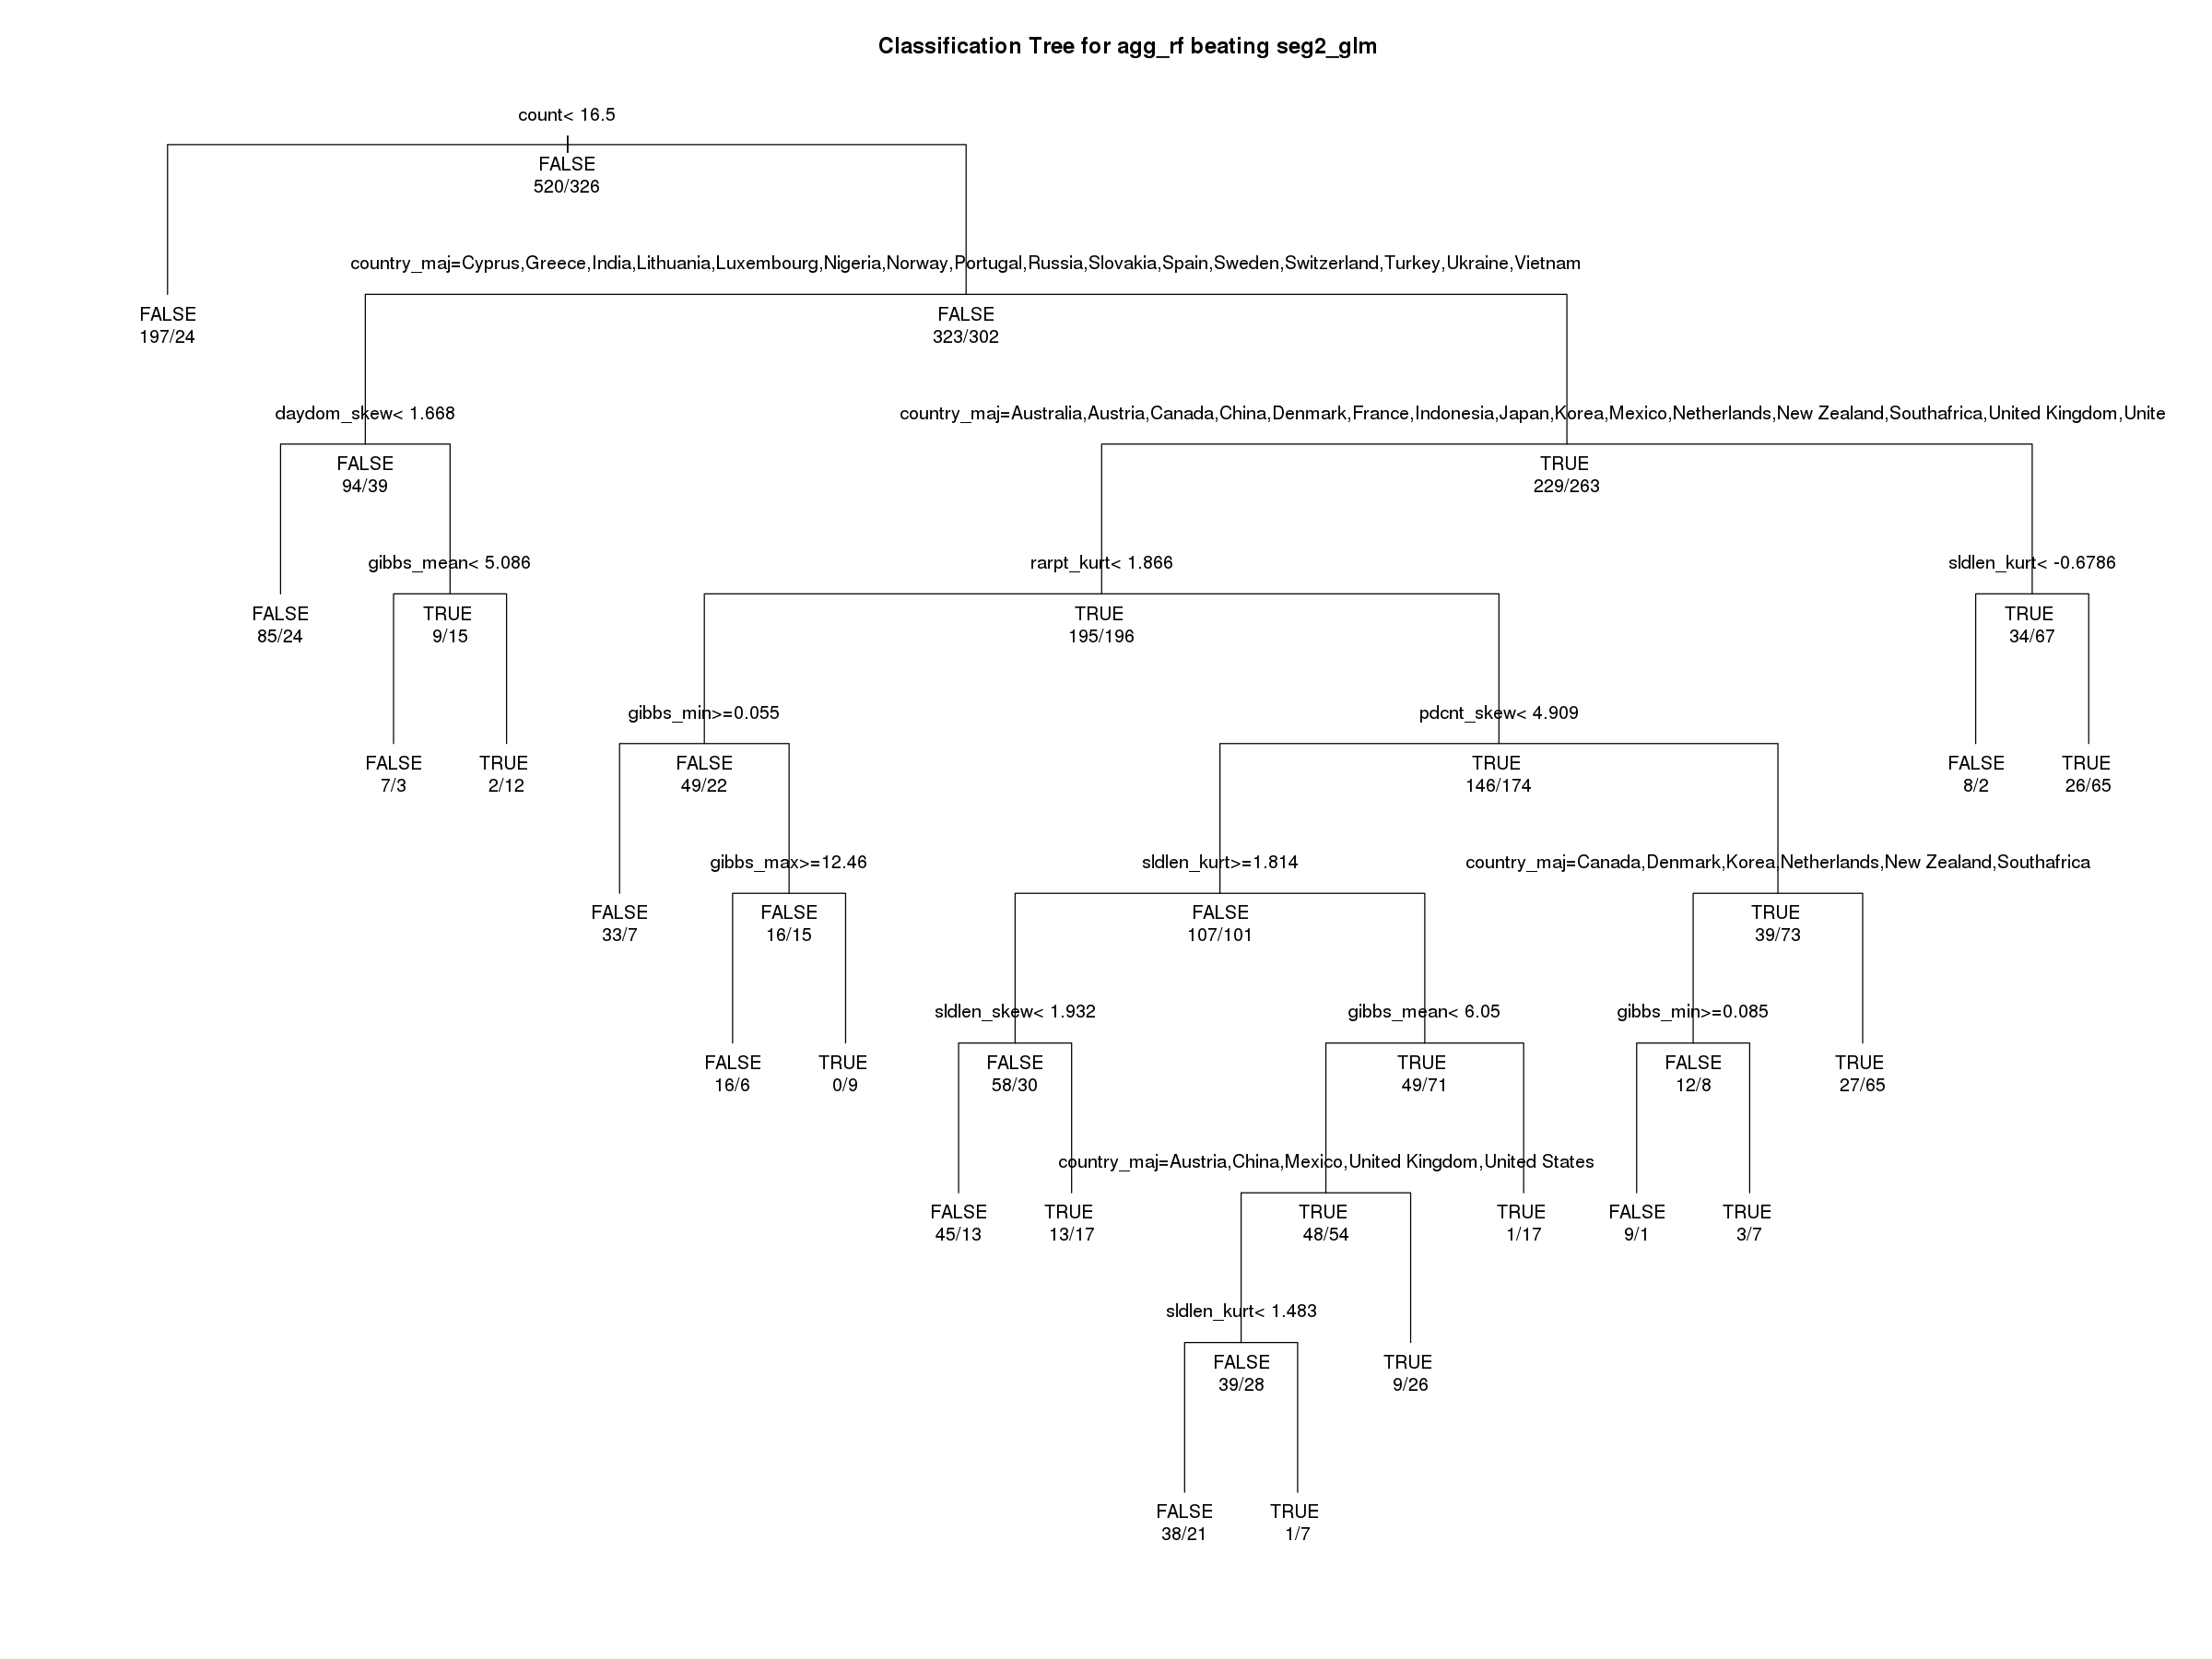

In [176]:
# plot tree
plot(fit, uniform=TRUE,
   main="Classification Tree for agg_rf beating seg2_glm", use.n=TRUE)
text(fit, use.n=TRUE, all=TRUE, cex=1, pretty=1)

Interpretation:
- If count of domains is less than or equal to 16, then seg2_glm wins
- Otherwise, if county_maj is one of Cyprus,Greece,India,Lithuania,Luxembourg,Nigeria,Norway,Portugal,Russia,Slovakia,Spain,Sweden,Switzerland,Turkey,Ukraine,Vietnam AND daydpom_skew is < 1.6568, then seg2_glm wins

In [152]:
library(rpart.plot)

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


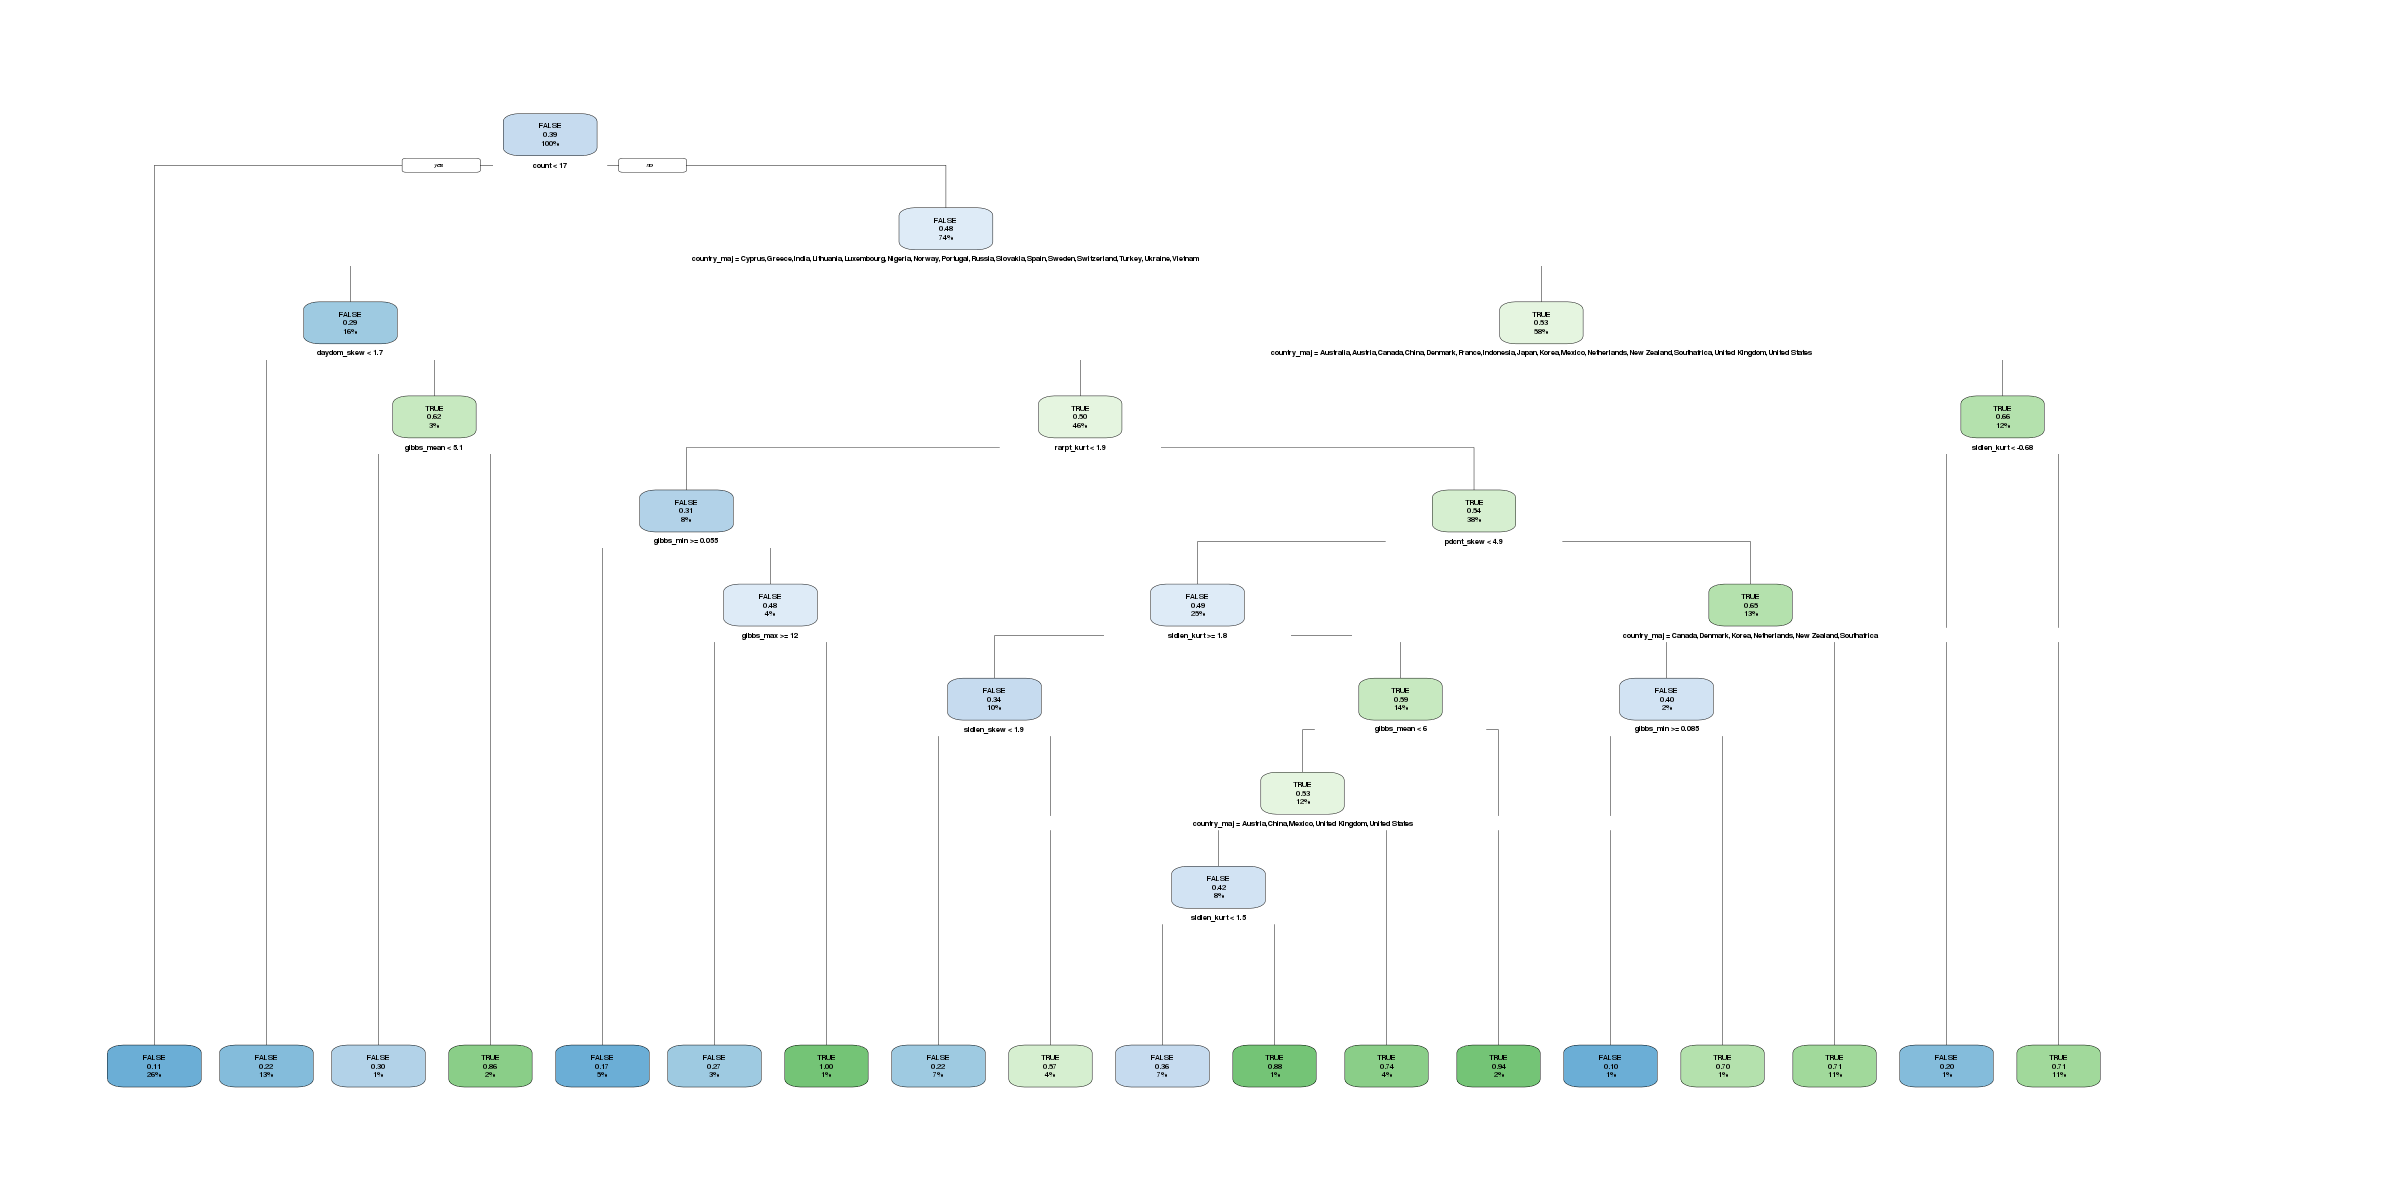

In [179]:
options(repr.plot.width=20, repr.plot.height=10)
rpart.plot(fit)

In [181]:
fit$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.05214724,0,1.0000000,1.000000,0.04342179
2,0.04141104,2,0.8957055,1.092025,0.04404740
3,0.01840491,6,0.7269939,1.058282,0.04384556
4,0.01687117,8,0.6901840,1.058282,0.04384556
5,0.01380368,11,0.6380368,1.061350,0.04386522
6,0.01226994,13,0.6104294,1.052147,0.04380546
7,0.01000000,17,0.5613497,1.042945,0.04374334


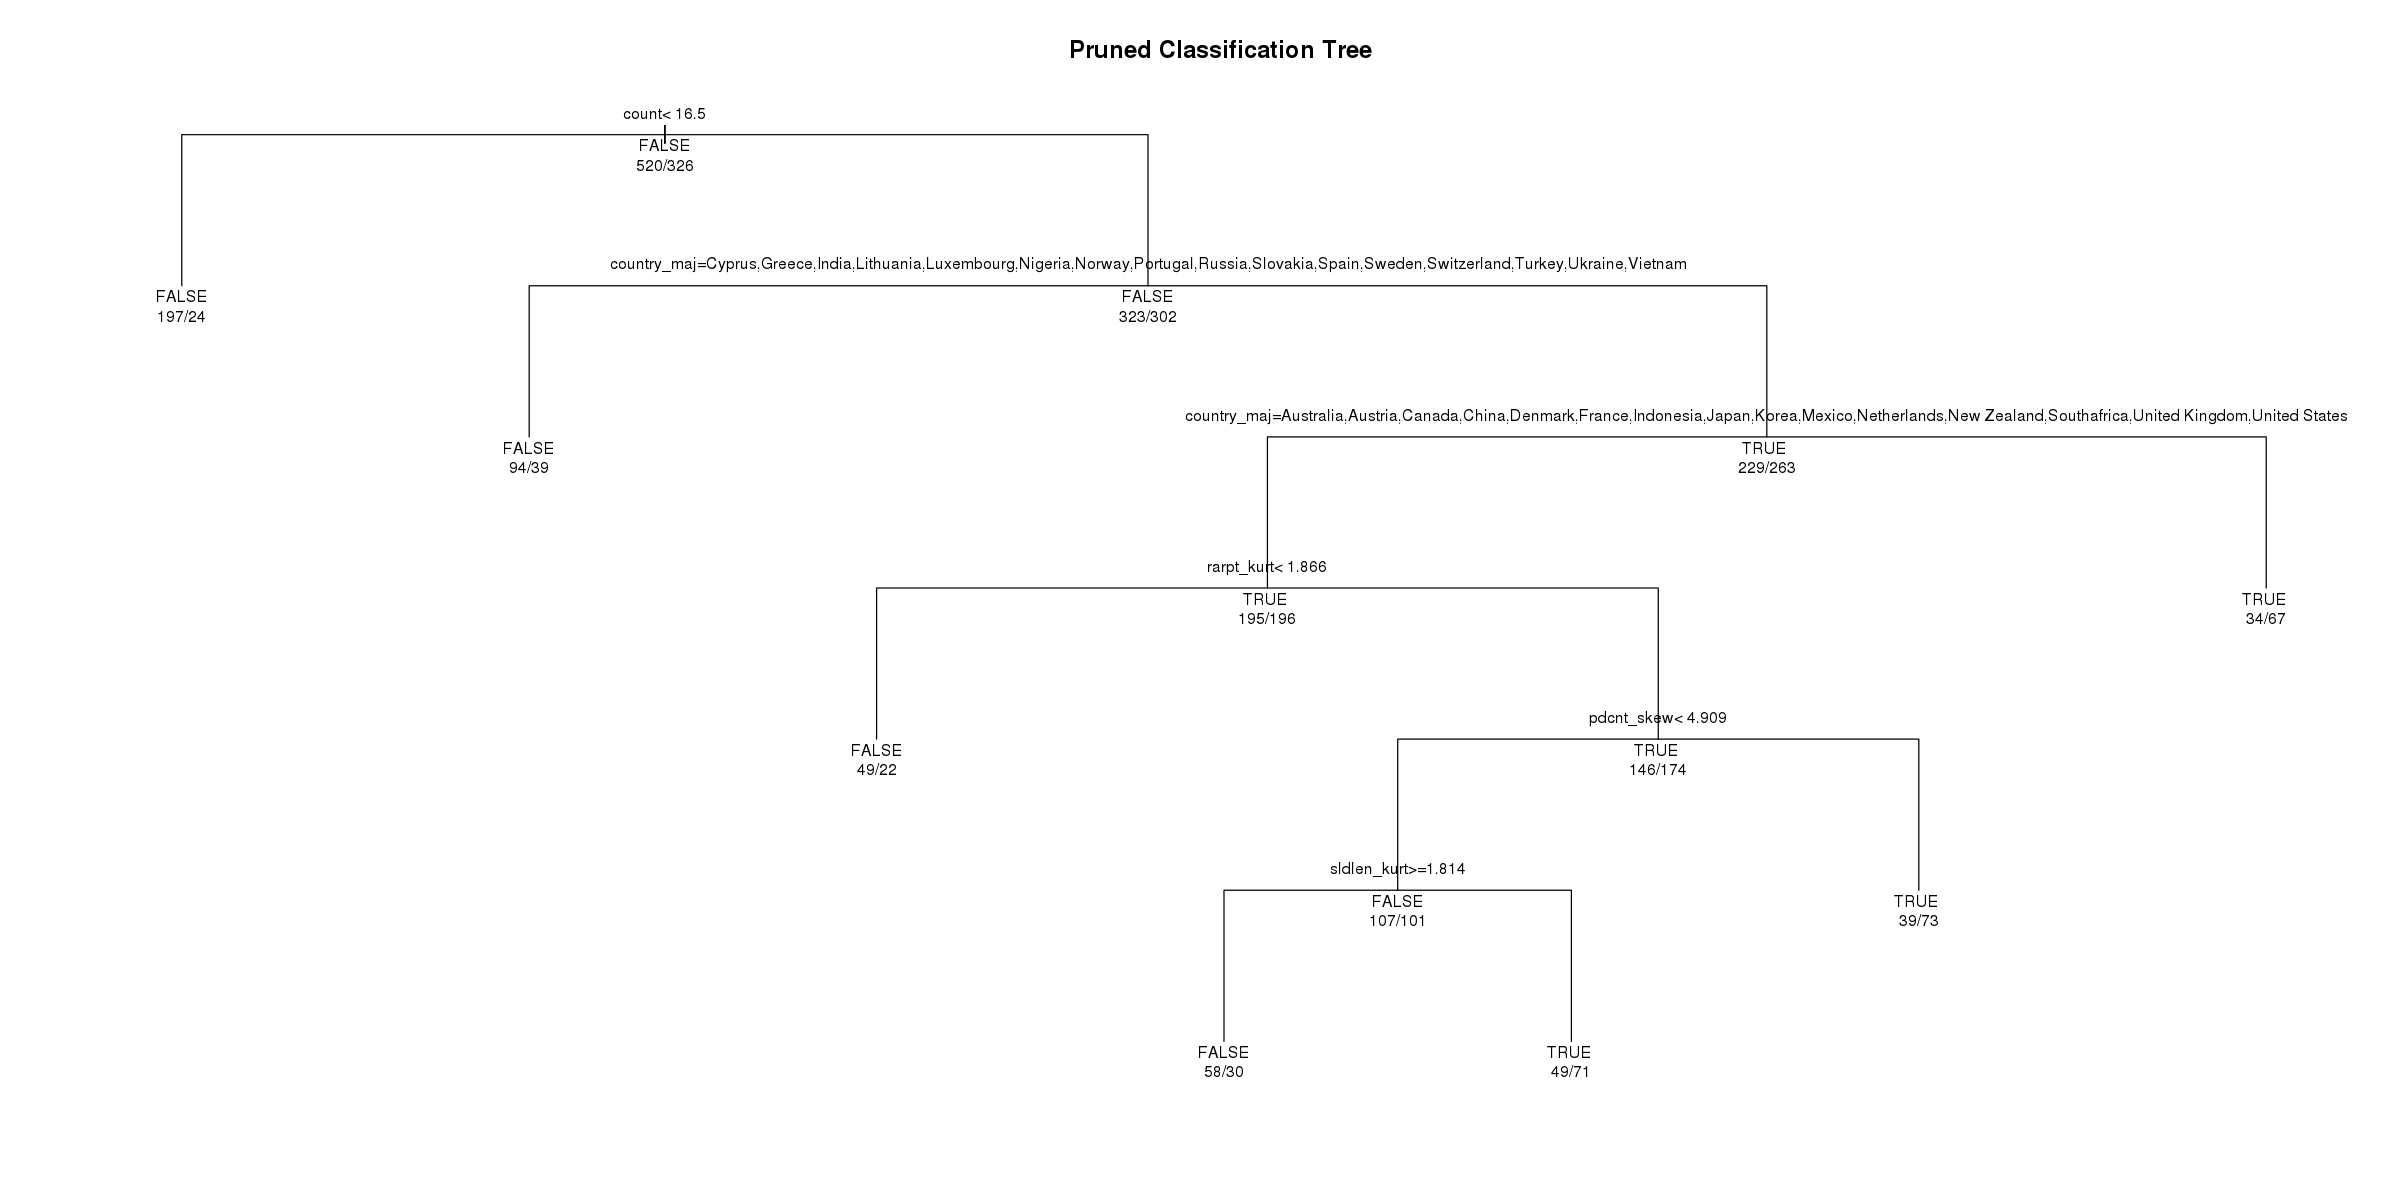

In [183]:
# prune the tree
# pfit<- prune(fit, cp=   fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
pfit<- prune(fit, cp= .02)

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Classification Tree ")
text(pfit, use.n=TRUE, all=TRUE, cex=.8, pretty=1)

In [184]:
t = factor(predict(fit,test,type="class"))

In [185]:
p = factor(test[['auc_win_glmagg_glmseg2_rfagg']])

In [186]:
length(t)
length(p)

[1] 212

[1] 0

In [189]:
test[['auc_win_aggseg2']]

[1]  TRUE  TRUE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE
 [13]  TRUE FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE
 [25] FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE
 [37]  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE
 [49] FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE
 [61]  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE
 [73] FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE
 [85] FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE
 [97]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE
[109] FALSE FALSE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE
[121] FALSE FALSE FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE
[133]  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE
[145] FALSE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE
[157] FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[169] FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE
[181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [190]:
factor(predict(fit,test,type="class"))

1     3     7    12    14    15    22    27    28    32    35    43    47 
 TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE 
   60    62    63    66    70    73    75    86    97   101   102   109   118 
 TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE 
  126   131   132   133   140   144   147   149   150   154   156   157   174 
FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE 
  176   183   187   192   198   202   208   213   214   216   233   257   269 
FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE 
  272   273   276   283   285   288   290   293   300   305   307   313   314 
 TRUE FALSE FALSE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE  TRUE FALSE  TRUE 
  318   321   325   329   350   353   354   355   360   363   366   370   380 
FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE 
  383   385   387   394   400   405   406   408   411   416   434   439   443 
 TRUE FALSE FALSE FALSE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE 
  451   454   460   462   469   471   481   485   492   496   502   506   510 
 TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE 
  514   518   525   529   531   540   550   551   556   561   565   568   571 
FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE 
  572   582   586   592   595   603   604   607   613   620   621   628   631 
FALSE  TRUE  TRUE FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE 
  632   634   636   641   642   645   647   652   659   661   670   676   681 
FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE  TRUE 
  689   691   701   705   707   708   715   729   731   746   758   768   773 
FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE 
  782   788   796   798   803   805   811   812   813   821   826   829   834 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  837   838   849   850   852   855   857   863   869   870   874   875   883 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  886   894   897   902   917   939   940   942   951   955   960   966   969 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  974   987   995  1001  1002  1003  1004  1009  1012  1016  1018  1019  1030 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
 1032  1035  1041  1049 
FALSE FALSE FALSE FALSE 
Levels: FALSE TRUE

In [191]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(fit,test,type="class")))#, positive='1')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   104   38
     TRUE     35   35
                                          
               Accuracy : 0.6557          
                 95% CI : (0.5875, 0.7194)
    No Information Rate : 0.6557          
    P-Value [Acc > NIR] : 0.5318          
                                          
                  Kappa : 0.2299          
                                          
 Mcnemar's Test P-Value : 0.8149          
                                          
            Sensitivity : 0.7482          
            Specificity : 0.4795          
         Pos Pred Value : 0.7324          
         Neg Pred Value : 0.5000          
             Prevalence : 0.6557          
         Detection Rate : 0.4906          
   Detection Prevalence : 0.6698          
      Balanced Accuracy : 0.6138          
                                          
       'Positive' Class : FALSE           
                     

In [193]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(pfit,test,type="class")))#, positive='1')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    95   47
     TRUE     30   40
                                          
               Accuracy : 0.6368          
                 95% CI : (0.5681, 0.7016)
    No Information Rate : 0.5896          
    P-Value [Acc > NIR] : 0.09175         
                                          
                  Kappa : 0.2265          
                                          
 Mcnemar's Test P-Value : 0.06825         
                                          
            Sensitivity : 0.7600          
            Specificity : 0.4598          
         Pos Pred Value : 0.6690          
         Neg Pred Value : 0.5714          
             Prevalence : 0.5896          
         Detection Rate : 0.4481          
   Detection Prevalence : 0.6698          
      Balanced Accuracy : 0.6099          
                                          
       'Positive' Class : FALSE           
                     

### seg_rf over seg2_glm

In [194]:
library(rpart)

In [219]:
train$auc_win_segseg2 = (train$auc_seg_rf/train$auc_seg2_glm)>1
test$auc_win_segseg2 = (test$auc_seg_rf/test$auc_seg2_glm)>1

In [199]:
names(train)

[1] "l10_seg2_glm"    "l10_seg_glm"     "l10_agg_glm"     "l10_seg2_rf"    
 [5] "l10_seg_rf"      "l10_agg_rf"      "auc_seg2_glm"    "auc_seg_glm"    
 [9] "auc_agg_glm"     "auc_seg2_rf"     "auc_seg_rf"      "auc_agg_rf"     
[13] "tld_reseller"    "count"           "ren_prp"         "tld_rat"        
[17] "country_maj"     "region_maj"      "country_cnt"     "region_cnt"     
[21] "daydom_min"      "daydom_max"      "daydom_mean"     "daydom_rng"     
[25] "daydom_std"      "daydom_skew"     "daydom_kurt"     "sldlen_min"     
[29] "sldlen_max"      "sldlen_mean"     "sldlen_rng"      "sldlen_std"     
[33] "sldlen_skew"     "sldlen_kurt"     "gibbs_min"       "gibbs_max"      
[37] "gibbs_mean"      "gibbs_rng"       "gibbs_std"       "gibbs_skew"     
[41] "gibbs_kurt"      "pdcnt_min"       "pdcnt_max"       "pdcnt_mean"     
[45] "pdcnt_rng"       "pdcnt_std"       "pdcnt_skew"      "pdcnt_kurt"     
[49] "rarpt_min"       "rarpt_max"       "rarpt_mean"      "rarpt_rng"      
[53] "rarpt_std"       "rarpt_skew"      "rarpt_kurt"      "auc_win"        
[57] "l10_win"         "l10_win_aggseg2" "auc_win_aggseg2" "auc_win_segseg2"

In [201]:
fit <- rpart(auc_win_segseg2 ~ .,
             method="class", 
             data=subset(train, select = -c(tld_reseller,
                                            l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,
                                            auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,
                                            auc_win,l10_win,l10_win_aggseg2,auc_win_aggseg2)))

In [202]:
summary(fit)

Call:
rpart(formula = auc_win_segseg2 ~ ., data = subset(train, select = -c(tld_reseller, 
    l10_seg2_glm, l10_seg_glm, l10_agg_glm, l10_seg2_rf, l10_seg_rf, 
    l10_agg_rf, auc_seg2_glm, auc_seg_glm, auc_agg_glm, auc_seg2_rf, 
    auc_seg_rf, auc_agg_rf, auc_win, l10_win, l10_win_aggseg2, 
    auc_win_aggseg2)), method = "class")
  n= 846 

          CP nsplit rel error   xerror       xstd
1 0.04687500      0  1.000000 1.000000 0.04407910
2 0.02812500      5  0.762500 1.015625 0.04421050
3 0.01458333      6  0.734375 0.984375 0.04394074
4 0.01406250      9  0.690625 0.975000 0.04385436
5 0.01250000     13  0.634375 0.981250 0.04391223
6 0.01093750     18  0.562500 0.975000 0.04385436
7 0.01000000     20  0.540625 0.975000 0.04385436

Variable importance
      count     tld_rat country_maj  daydom_max  daydom_rng daydom_mean 
         12          12           8           7           7           7 
  gibbs_rng     ren_prp  pdcnt_mean   pdcnt_std  gibbs_mean  pdcnt_kurt 
          6  

In [203]:
levels(train$country_maj)

[1] ""               "Argentina"      "Australia"      "Austria"       
 [5] "Belgium"        "Brazil"         "Bulgaria"       "Canada"        
 [9] "Cayman Islands" "China"          "Cyprus"         "Czech Republic"
[13] "Denmark"        "Finland"        "France"         "Germany"       
[17] "Gibraltor"      "Greece"         "India"          "Indonesia"     
[21] "Ireland"        "Israel"         "Italy"          "Japan"         
[25] "Korea"          "Lithuania"      "Luxembourg"     "Mexico"        
[29] "Netherlands"    "New Zealand"    "Nigeria"        "Norway"        
[33] "Poland"         "Portugal"       "Russia"         "Singapore"     
[37] "Slovakia"       "South Africa"   "Southafrica"    "Spain"         
[41] "Sweden"         "Switzerland"    "Turkey"         "Ukraine"       
[45] "United Kingdom" "United States"  "USA"            "Vietnam"

In [204]:
names(fit)

[1] "frame"               "where"               "call"               
 [4] "terms"               "cptable"             "method"             
 [7] "parms"               "control"             "functions"          
[10] "numresp"             "splits"              "csplit"             
[13] "variable.importance" "y"                   "ordered"

In [205]:
fit

n= 846 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

   1) root 846 320 FALSE (0.6217494 0.3782506)  
     2) count< 16.5 221  25 FALSE (0.8868778 0.1131222) *
     3) count>=16.5 625 295 FALSE (0.5280000 0.4720000)  
       6) country_maj=Denmark,Greece,India,Indonesia,Lithuania,Luxembourg,Norway,Portugal,Russia,Slovakia,Spain,Sweden,Turkey,United Kingdom 151  43 FALSE (0.7152318 0.2847682)  
        12) daydom_skew< 1.740189 127  30 FALSE (0.7637795 0.2362205) *
        13) daydom_skew>=1.740189 24  11 TRUE (0.4583333 0.5416667)  
          26) gibbs_mean< 5.17202 14   4 FALSE (0.7142857 0.2857143) *
          27) gibbs_mean>=5.17202 10   1 TRUE (0.1000000 0.9000000) *
       7) country_maj=Argentina,Australia,Austria,Brazil,Bulgaria,Canada,Cayman Islands,China,Cyprus,Czech Republic,France,Germany,Italy,Japan,Korea,Mexico,Netherlands,New Zealand,Nigeria,Poland,South Africa,Southafrica,Switzerland,Ukraine,United States,Vietnam 474 222 TRUE (0.4683544 0.5316456)

Warning message in plot.window(...):
“"use.n" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"use.n" is not a graphical parameter”
Warning message in title(...):
“"use.n" is not a graphical parameter”


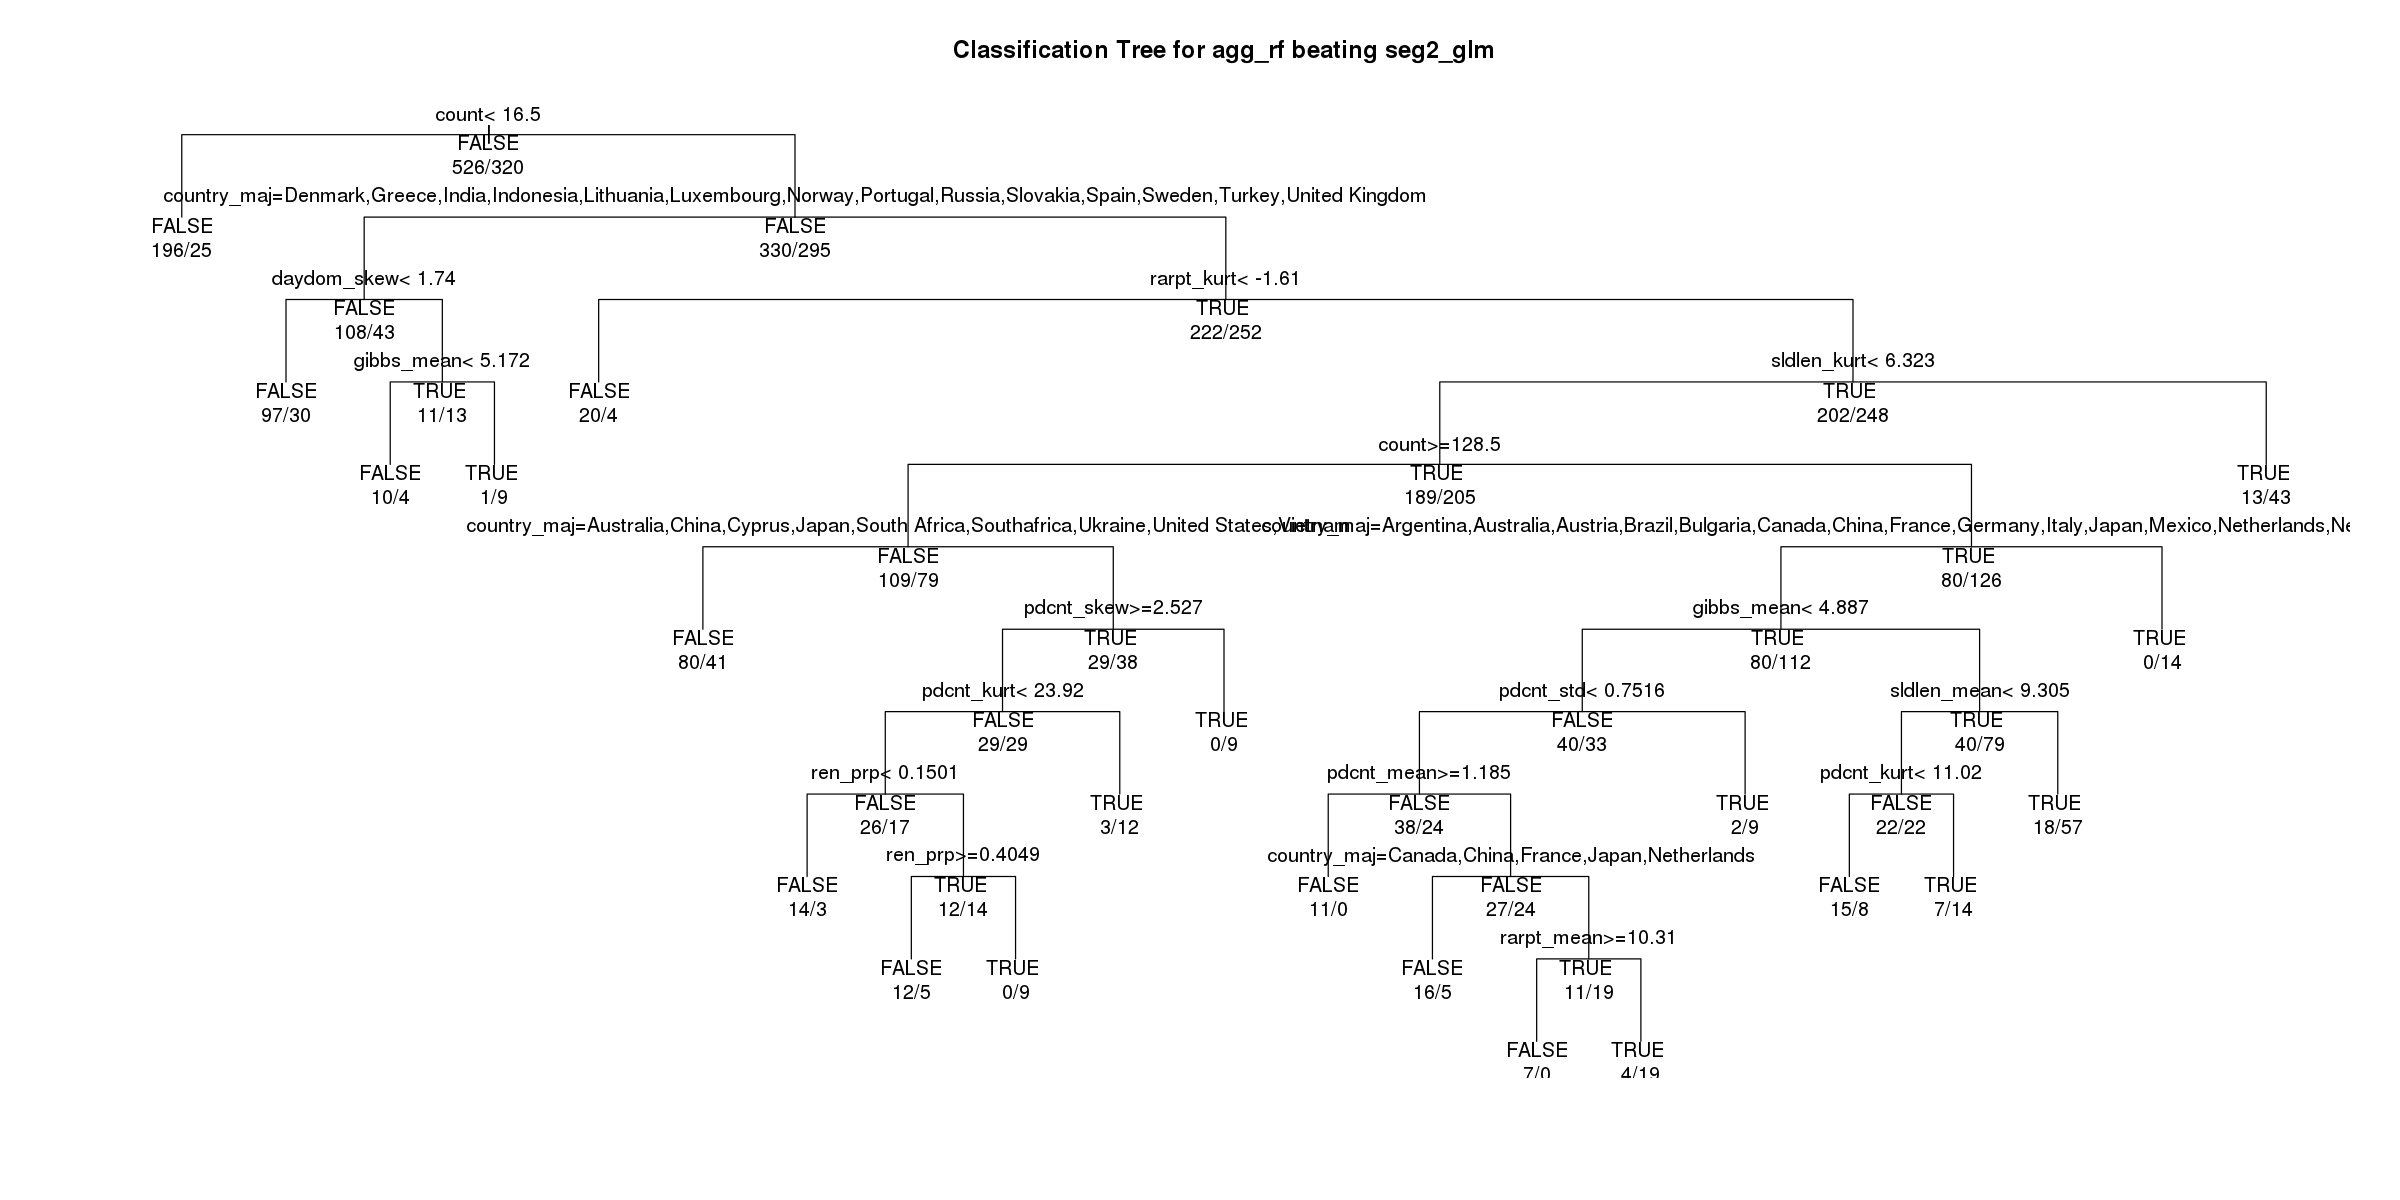

In [206]:
# plot tree
plot(fit, uniform=TRUE,
   main="Classification Tree for agg_rf beating seg2_glm", use.n=TRUE)
text(fit, use.n=TRUE, all=TRUE, cex=1, pretty=1)

Interpretation:
- If count of domains is less than or equal to 16, then seg2_glm wins
- Otherwise, if county_maj is one of <s>Cyprus,</s> **Denmark**, Greece, India, **Indonesia**,Lithuania, Luxembourg, <s>Nigeria</s>, Norway, Portugal, Russia, Slovakia, Spain, Sweden, <s>Switzerland</s>, Turkey, <s>Ukraine,Vietnam</s>, **United Kindon** AND daydpom_skew is < <s>1.68</s> 1.74, then seg2_glm wins... IF  daydpom_skew is >= <s>1.68</s> 1.74 but gibbs_mean < 5.172 then seg2_glm wins

In [207]:
library(rpart.plot)

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


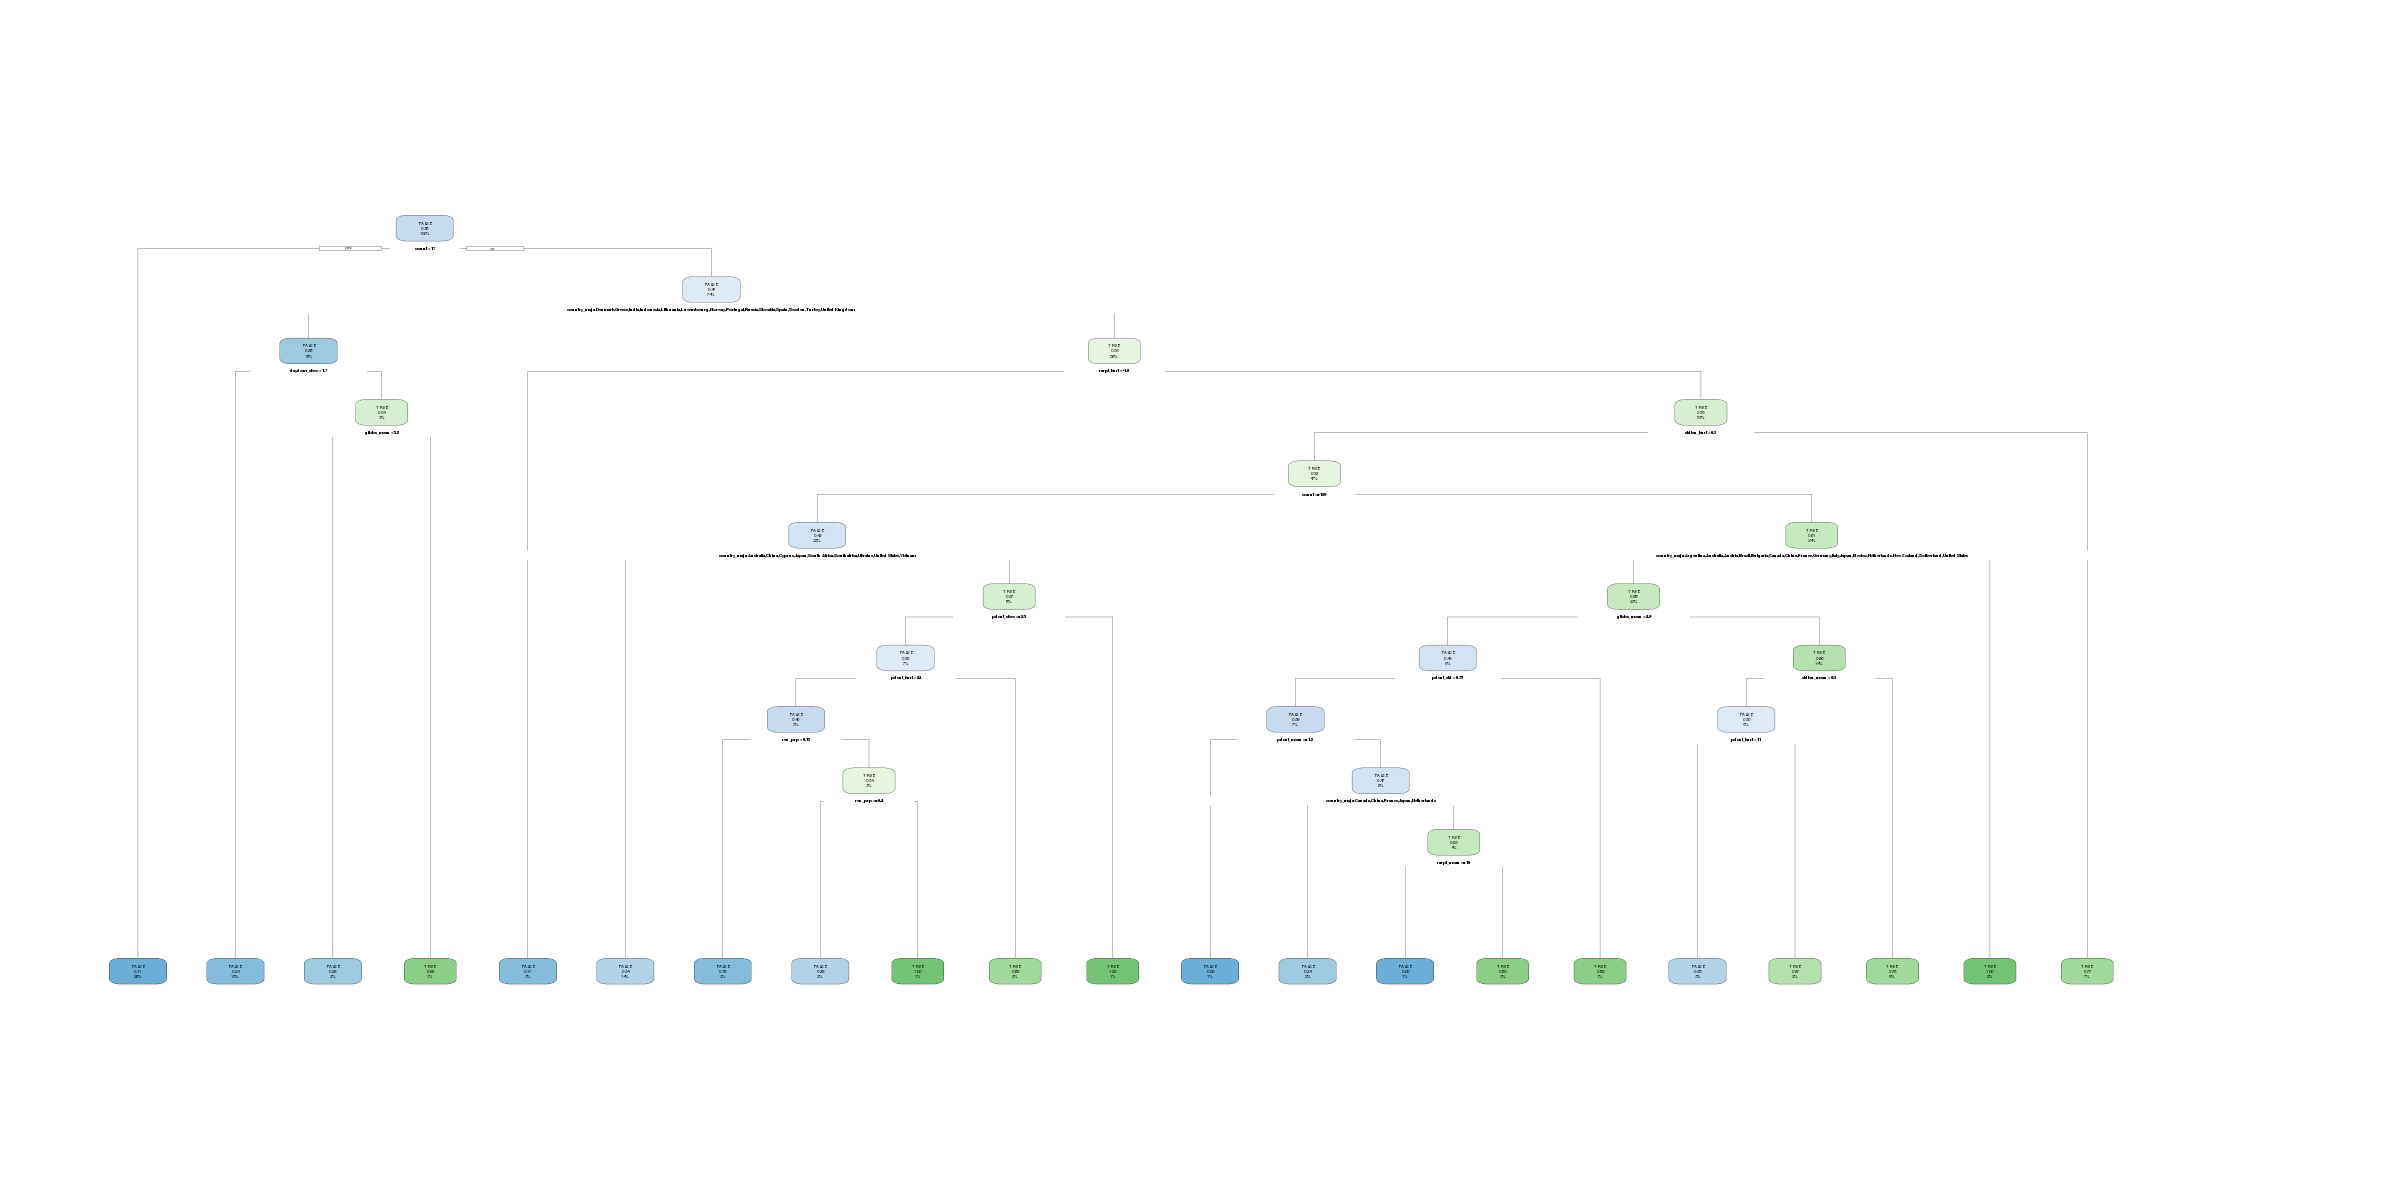

In [209]:
options(repr.plot.width=20, repr.plot.height=10)
rpart.plot(fit)

In [210]:
fit$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.04687500,0,1.000000,1.000000,0.04407910
2,0.02812500,5,0.762500,1.015625,0.04421050
3,0.01458333,6,0.734375,0.984375,0.04394074
4,0.01406250,9,0.690625,0.975000,0.04385436
5,0.01250000,13,0.634375,0.981250,0.04391223
6,0.01093750,18,0.562500,0.975000,0.04385436
7,0.01000000,20,0.540625,0.975000,0.04385436


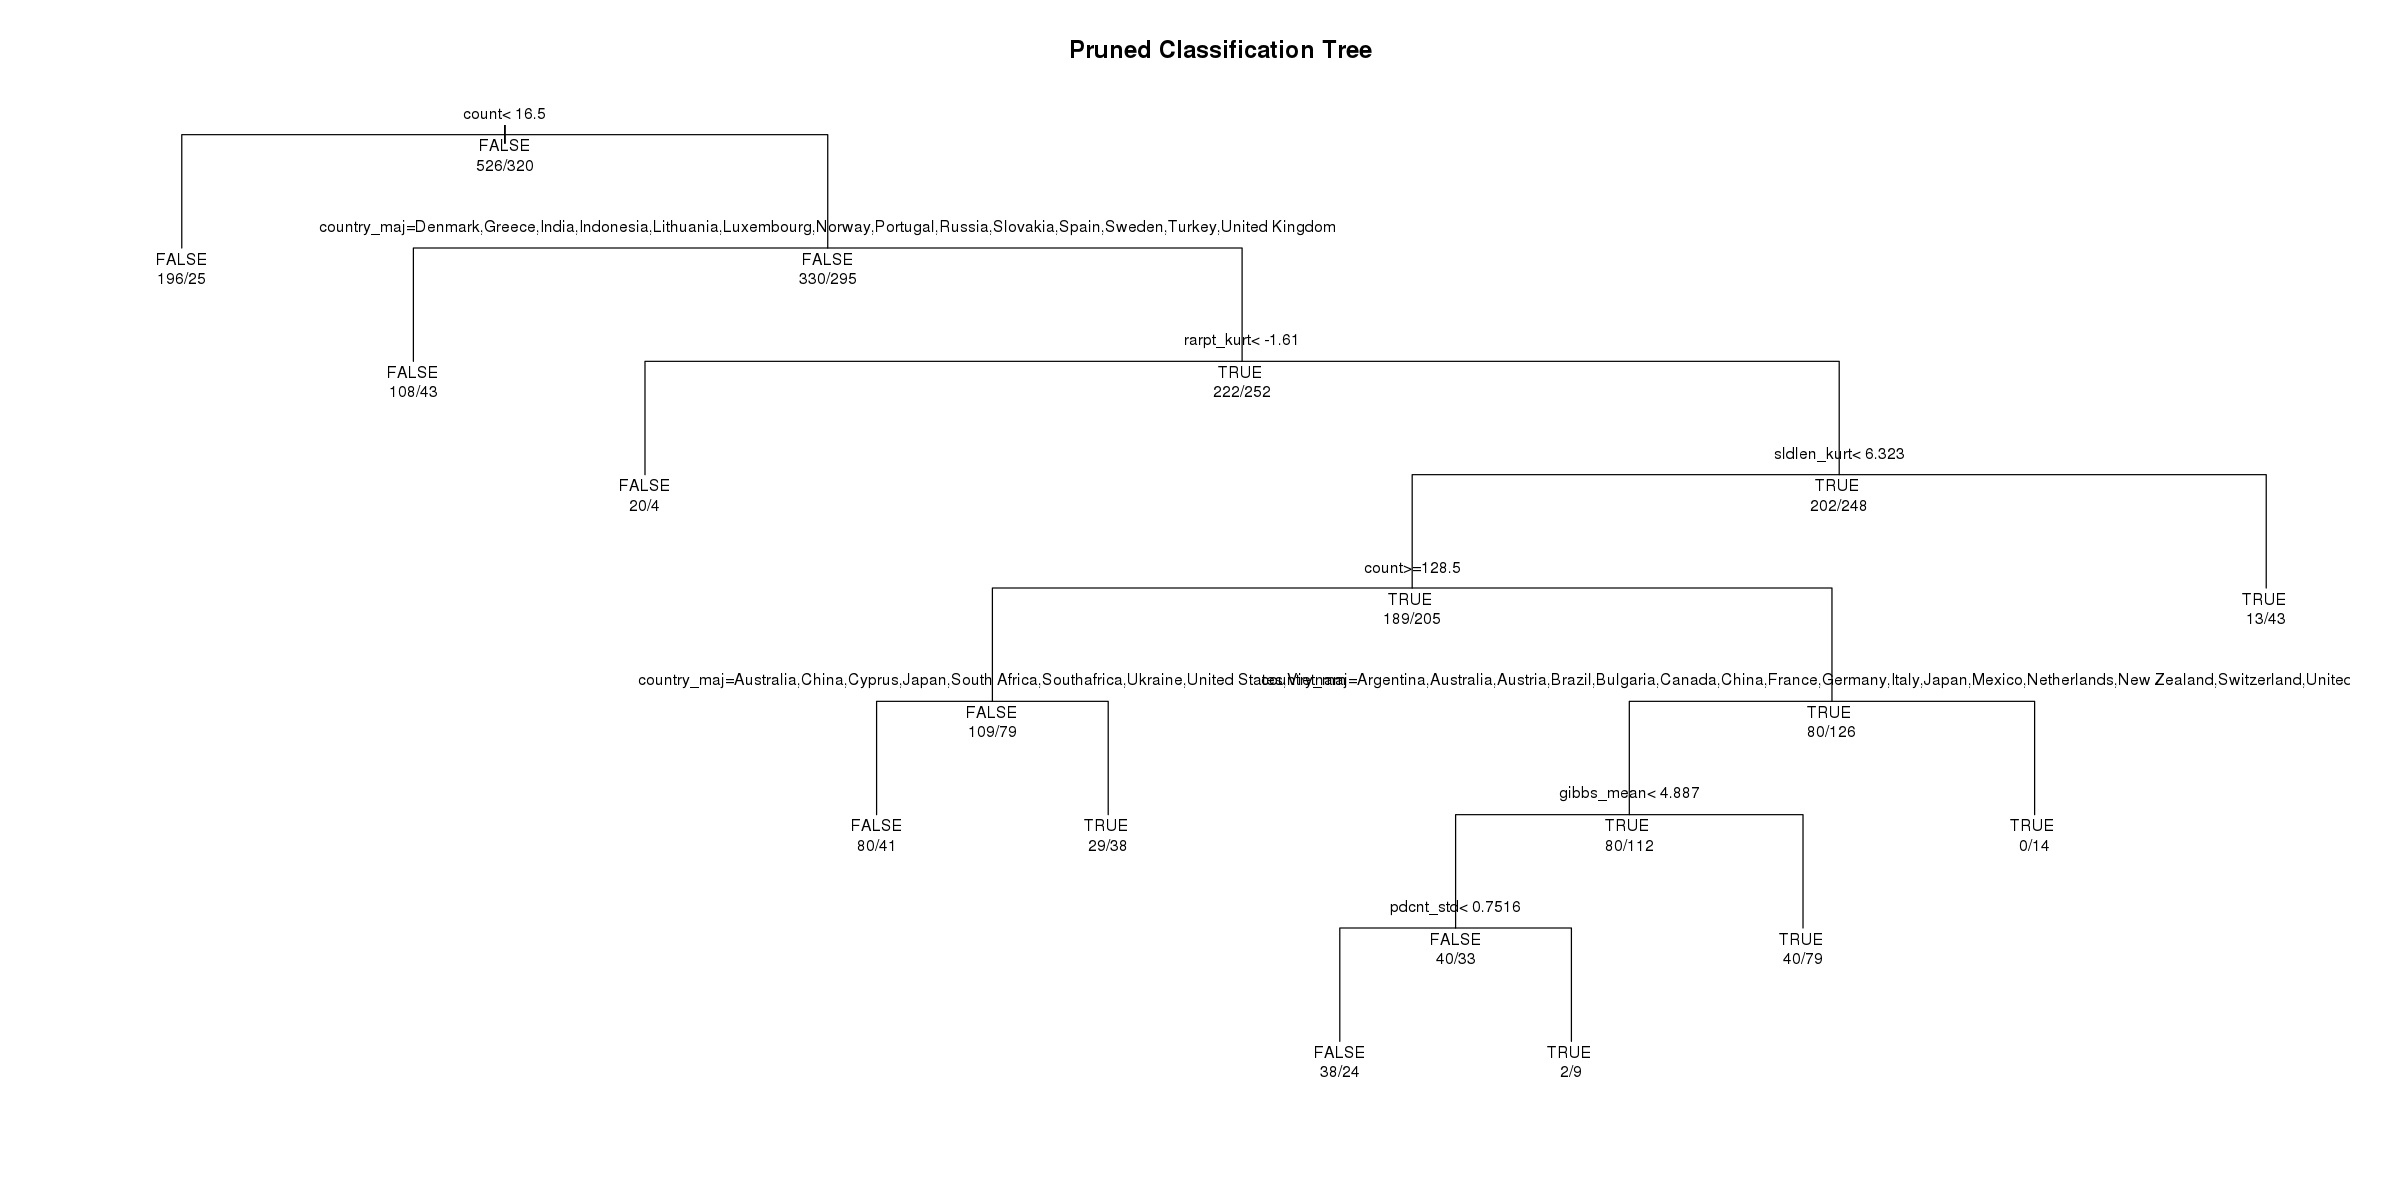

In [211]:
# prune the tree
pfit<- prune(fit, cp=   fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
# pfit<- prune(fit, cp= .02)

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Classification Tree ")
text(pfit, use.n=TRUE, all=TRUE, cex=.8, pretty=1)

In [228]:
summary(train$count)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    1.00    15.25    72.50   956.02   316.75 72690.00 

In [220]:
t = factor(predict(fit,test,type="class"))

In [221]:
p = factor(test[['auc_win_glmagg_glmseg2_rfagg']])

In [222]:
length(t)
length(p)

[1] 212

[1] 0

In [224]:
test[['auc_win_segseg2']]

[1]  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13]  TRUE FALSE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE
 [25] FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE  TRUE FALSE
 [37]  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE  TRUE
 [49]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE
 [61]  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE FALSE
 [73] FALSE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE
 [85] FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE
 [97] FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE
[109] FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
[121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE
[133] FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE
[145] FALSE FALSE  TRUE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE
[157] FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[169] FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE  TRUE FALSE FALSE  TRUE
[181] FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE
[193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [225]:
factor(predict(fit,test,type="class"))

1     3     7    12    14    15    22    27    28    32    35    43    47 
 TRUE  TRUE FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE 
   60    62    63    66    70    73    75    86    97   101   102   109   118 
 TRUE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE 
  126   131   132   133   140   144   147   149   150   154   156   157   174 
FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE 
  176   183   187   192   198   202   208   213   214   216   233   257   269 
FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE 
  272   273   276   283   285   288   290   293   300   305   307   313   314 
FALSE FALSE  TRUE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE 
  318   321   325   329   350   353   354   355   360   363   366   370   380 
FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  383   385   387   394   400   405   406   408   411   416   434   439   443 
 TRUE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE 
  451   454   460   462   469   471   481   485   492   496   502   506   510 
FALSE  TRUE  TRUE  TRUE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE 
  514   518   525   529   531   540   550   551   556   561   565   568   571 
FALSE  TRUE FALSE FALSE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE 
  572   582   586   592   595   603   604   607   613   620   621   628   631 
FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE FALSE FALSE FALSE 
  632   634   636   641   642   645   647   652   659   661   670   676   681 
 TRUE FALSE FALSE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE 
  689   691   701   705   707   708   715   729   731   746   758   768   773 
FALSE  TRUE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE FALSE 
  782   788   796   798   803   805   811   812   813   821   826   829   834 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  837   838   849   850   852   855   857   863   869   870   874   875   883 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  886   894   897   902   917   939   940   942   951   955   960   966   969 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  974   987   995  1001  1002  1003  1004  1009  1012  1016  1018  1019  1030 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
 1032  1035  1041  1049 
FALSE FALSE FALSE FALSE 
Levels: FALSE TRUE

In [226]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_segseg2']]),
                factor(predict(fit,test,type="class")))#, positive='1')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   107   30
     TRUE     49   26
                                          
               Accuracy : 0.6274          
                 95% CI : (0.5585, 0.6926)
    No Information Rate : 0.7358          
    P-Value [Acc > NIR] : 0.99980         
                                          
                  Kappa : 0.1355          
                                          
 Mcnemar's Test P-Value : 0.04285         
                                          
            Sensitivity : 0.6859          
            Specificity : 0.4643          
         Pos Pred Value : 0.7810          
         Neg Pred Value : 0.3467          
             Prevalence : 0.7358          
         Detection Rate : 0.5047          
   Detection Prevalence : 0.6462          
      Balanced Accuracy : 0.5751          
                                          
       'Positive' Class : FALSE           
                     

In [227]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(pfit,test,type="class")))#, positive='1')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   107   35
     TRUE     41   29
                                        
               Accuracy : 0.6415        
                 95% CI : (0.573, 0.706)
    No Information Rate : 0.6981        
    P-Value [Acc > NIR] : 0.9677        
                                        
                  Kappa : 0.1715        
                                        
 Mcnemar's Test P-Value : 0.5663        
                                        
            Sensitivity : 0.7230        
            Specificity : 0.4531        
         Pos Pred Value : 0.7535        
         Neg Pred Value : 0.4143        
             Prevalence : 0.6981        
         Detection Rate : 0.5047        
   Detection Prevalence : 0.6698        
      Balanced Accuracy : 0.5880        
                                        
       'Positive' Class : FALSE         
                                        